# CSE 415 Deep Learning Assignment (A6)
Please go through the entire assignment, and read all lines of code, including the comments. However, only changes to areas of the code marked "**TO DO**" will be graded.

# Part 0: Pytorch Setup Code
Write your name where designated. Format: First name followed by last name with a space in between, and initials capitalized. For example:

name = 'Bindita Chaudhuri'

In [2]:
# This shows how to connect your google drive account with a colab instance.

# Load the Drive helper and mount; this will prompt for authorization 
# (Login to google account; allow access, copy the code and paste it below and then press enter)
from google.colab import drive
drive.mount('/gdrive')

# create a folder named CSE415 in your Drive
import os 
BASE_PATH = '/gdrive/My Drive/CSE415/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
    
# now let's test that Google Drive is up and running. 
!ls "/gdrive/My Drive/CSE415"

# The following line will create a text file "foo.txt" in the created folder and then remove it
!echo "Hello Google Drive" > "/gdrive/My Drive/CSE415/foo.txt"
!cat "/gdrive/My Drive/CSE415/foo.txt"
!rm "/gdrive/My Drive/CSE415/foo.txt"

import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.3.1
# CUDA enabled: True

import torch.nn as nn
import numpy as np
import glob, re, pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from torchvision import datasets, transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import h5py, tqdm
import sys
sys.path.append(BASE_PATH)

# TODO: done
# write your name here in the format mentioned above
name = 'Jia-Jia Lin'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
cifar10  language
Hello Google Drive
Version 1.4.0
CUDA enabled: True


In [3]:
# Some useful save, restoring and conversion functions are provided below. No need to change them.

!pip3 install matplotlib-label-lines
from labellines import labelLines

class pt_util(object):
    # This does more than the simple Pytorch restore. It checks that the names 
    # of variables match, and if they don't doesn't throw a fit. It is similar 
    # to how Caffe acts. This is especially useful if you decide to change your
    # network architecture but don't want to retrain from scratch.
    @staticmethod
    def restore(net, save_file):
        """ Args:
        net(torch.nn.Module): The net to restore
        save_file(str): The file path
        """
        net_state_dict = net.state_dict()
        restore_state_dict = torch.load(save_file)

        restored_var_names = set()

        print('Restoring:')
        for var_name in restore_state_dict.keys():
            if var_name in net_state_dict:
                var_size = net_state_dict[var_name].size()
                restore_size = restore_state_dict[var_name].size()
                if var_size != restore_size:
                    print('Shape mismatch for var', var_name, 'expected', var_size, 'got', restore_size)
                else:
                    if isinstance(net_state_dict[var_name], torch.nn.Parameter):
                        # backwards compatibility for serialized parameters
                        net_state_dict[var_name] = restore_state_dict[var_name].data
                    try:
                        net_state_dict[var_name].copy_(restore_state_dict[var_name])
                        print(str(var_name)+' -> \t'+str(var_size)+' = '+str(int(np.prod(var_size)*4 / 10**6)) + 'MB')
                        restored_var_names.add(var_name)
                    except:
                        print('While copying the parameter named {}, whose dimensions in the model are'
                              ' {} and whose dimensions in the checkpoint are {}, ...'.format(
                                  var_name, var_size, restore_size))
                        raise

        ignored_var_names = sorted(list(set(restore_state_dict.keys()) - restored_var_names))
        unset_var_names = sorted(list(set(net_state_dict.keys()) - restored_var_names))
        print('')
        if len(ignored_var_names) == 0:
            print('Restored all variables')
        else:
            print('Did not restore:\n\t' + '\n\t'.join(ignored_var_names))
        if len(unset_var_names) == 0:
            print('No new variables')
        else:
            print('Initialized but did not modify:\n\t' + '\n\t'.join(unset_var_names))

        print('Restored %s' % save_file)
        
    # Restores the last saved network in a folder using file write time.
    @staticmethod
    def restore_latest(net, folder):
        """
        Args:
          net(torch.nn.module): The net to restore
          folder(str): The folder path
        Returns:
          int: Attempts to parse the epoch from the state and returns it if possible. Otherwise returns 0.
        """
        checkpoints = sorted(glob.glob(folder + '/*.pt'), key=os.path.getmtime)
        start_it = 0
        if len(checkpoints) > 0:
            pt_util.restore(net, checkpoints[-1])
            start_it = int(re.findall(r'\d+', checkpoints[-1])[-1])
        return start_it

    # Saves the network and optionally deletes old save files. 
    # If num_to_keep is 0, it won't remove any.
    @staticmethod
    def save(net, file_name, num_to_keep=1):
        """
        Args:
        net(torch.nn.module): The network to save
        file_name(str): the path to save the file.
        num_to_keep(int): Specifies how many previous saved states to keep once this one has been saved.
            Defaults to 1. Specifying < 0 will not remove any previous saves.
        """
        folder = os.path.dirname(file_name)
        if not os.path.exists(folder):
            os.makedirs(folder)
        torch.save(net.state_dict(), file_name)
        extension = os.path.splitext(file_name)[1]
        checkpoints = sorted(glob.glob(folder + '/*' + extension), key=os.path.getmtime)
        print('Saved %s\n' % file_name)
        if num_to_keep > 0:
            for ff in checkpoints[:-num_to_keep]:
                os.remove(ff)
                

    @staticmethod
    def to_numpy(array):
        if isinstance(array, torch.Tensor):
            return array.detach().cpu().numpy()
        elif isinstance(array, dict):
            return {key: pt_util.to_numpy(val) for key, val in array.items()}
        else:
            return np.asarray(array)

    @staticmethod
    def from_numpy(np_array):
        if isinstance(np_array, list):
            try:
                np_array = np.stack(np_array, 0)
            except ValueError:
                np_array = np.stack([from_numpy(val) for val in np_array], 0)
        elif isinstance(np_array, dict):
            return {key: from_numpy(val) for key, val in np_array.items()}
        np_array = np.asarray(np_array)
        if np_array.dtype == np.uint32:
            print("numpy -> torch dtype uint32 not supported, using int32")
            np_array = np_array.astype(np.int32)
        elif np_array.dtype == np.dtype("O"):
            print("numpy -> torch dtype Object not supported, returning numpy array")
            return np_array
        elif np_array.dtype.type == np.str_:
            print("numpy -> torch dtype numpy.str_ not supported, returning numpy array")
            return np_array
        return torch.from_numpy(np_array)

    @staticmethod
    def write_log(filename, data):
        """Pickles and writes data to a file
        Args:
            filename(str): File name
            data(pickleable object): Data to save
        """
        if not os.path.exists(os.path.dirname(filename)):
          os.makedirs(os.path.dirname(filename))
        pickle.dump(data, open(filename, 'wb')) 

    def read_log(filename, default_value=None):
        """Reads pickled data or returns the default value if none found
        Args:
            filename(str): File name
            default_value(anything): Value to return if no file is found
        Returns:
            unpickled file
        """
        if os.path.exists(filename):
            return pickle.load(open(filename, 'rb'))
        return default_value
    
    # Create plots
    @staticmethod
    def plot(x_values, y_values, title, xlabel, ylabel, plotlabel):
        """Plots a line graph
        Args:
            x_values(list or np.array): x values for the line
            y_values(list or np.array): y values for the line
            title(str): Title for the plot
            xlabel(str): Label for the x axis
            ylabel(str): label for the y axis
        """
        plt.figure(figsize=(20, 10))
        plt.plot(x_values, y_values, label=plotlabel, color='b')
        labelLines(plt.gca().get_lines(), color='b',fontsize=13)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    def to_scaled_uint8(array):
        """Returns a normalized uint8 scaled to 0-255. This is useful for showing images especially of floats.
        Args:
            array(np.array): The array to normalize
        Returns:
            np.array normalized and of type uint8
        """
        array = np.array(array, dtype=np.float32)
        array -= np.min(array)
        array *= (255. / np.max(array))
        array = array.astype(np.uint8)
        return array

# Part 1: Classification Network for CIFAR-10

# 1.1 Loading and transforming data

CIFAR-10 data consists of 60000 32x32 images, belonging to 10 classes. More details can be found here:
https://www.cs.toronto.edu/~kriz/cifar.html

Note: Each image is a matrix of shape width x height (W x H) with 3 channels (C).

The code for loading the dataset and transforming the data accordingly is provided. 
The transform *ToTensor* converts the output from the dataset to be a tensor in CxHxW format.
One type of data augmentation - data normalization, is shown in the transforms. You have to add at least 2 of the following data augmentations in 'transform_train' (try to understand which ones you need, and what parameters you should choose for them):

- RandomHorizontalFlip
- RandomCrop
- ColorJitter
- RandomRotation


# 1.2 Defining network

You need to define a convolutional neural network (CNN) to classify the data into its classes. Sample code for classification of MNIST (handwritten digits dataset) is given here: https://github.com/pytorch/examples/blob/master/mnist/main.py

You will define the network layers in the `__init__` function, and the forward call will pass the data through those layers. The network should be as follows:

- One 3x3 convolution layer with 32 filters.
- One 2x2 maxpooling layer
- One 3x3 convolution layer with 64 filters. 
- One 3x3 convolution layer with 64 filters. 
- One 2x2 maxpooling layer
- One 3x3 convolution layer with 128 filters. 
- One 3x3 convolution layer with 128 filters.
- One 2x2 maxpooling layer
- One fully connected layer with 512 outputs.
- Then the final classification layer with 10 outputs.

- Every convolution layer should be followed by ReLU nonlinearity followed by batch normalization. Use padding in every convolution layer to retain input image size.
        


# Helpful functions
- https://pytorch.org/docs/stable/tensors.html
- https://pytorch.org/docs/stable/nn.html
- You can call `pt_util.to_numpy(x)` to get a numpy array from a torch tensor x.
- `pt_util.from_numpy(x)` makes a torch Tensor from the numpy array x.

# Common Oopsies
- __Q__ It only runs for one iteration and says it's done: __A__ We provided code that automatically loads the most recent file. If you don't want to start from that checkpoint, simply find it in your google drive and delete it.
- __Q__ I want to save more than just the last checkpoint: __A__ You can change the save function to save any number of previous checkpoints. You can also tell it to save all of them (not delete anything), by passing in 0.
- __Q__ Pytorch is saying things are the wrong shape: __A__ You can easily reshape things using the `view` function (https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view). It is like the Numpy `reshape` function.
- __Q__ Pytorch is saying things are on the wrong device: __A__ You can move data between devices with the `.to(device)` call. Generally, all arguments to a function will need to be on the same device.

In [12]:
# Data augmentation

transform_train = transforms.Compose([
    # TO DO: done
    transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(60),
    transforms.RandomRotation(180),

    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the dataset

DATA_PATH = BASE_PATH + 'cifar10/'
data_train = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)
data_test = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)


# This is where you define your network architecture.
# You can use that as a guide, but make sure you understand what it all does.

class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        self.best_accuracy = -1
        # TO DO: fix
        # One 3x3 convolution layer with 32 filters.
        # kernel = matrix that you apply per section of image
        # filter = bunch of kernels together
        # channel = depth of image (ex: RGB, first layer only)
        # note: each filters is learning something different (ex: color, edges)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)

        # One 2x2 maxpooling layer
        self.mp1 = nn.MaxPool2d(2)

        # One 3x3 convolution layer with 64 filters.
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        # One 3x3 convolution layer with 64 filters.
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)

        # One 2x2 maxpooling layer
        self.mp2 = nn.MaxPool2d(2)

        # One 3x3 convolution layer with 128 filters.
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(128)
        # One 3x3 convolution layer with 128 filters.
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm2d(128)

        # One 2x2 maxpooling layer
        self.mp3 = nn.MaxPool2d(2)

        # One fully connected layer with 512 outputs.
        self.fc1 = nn.Linear(2048, 512)
        # Then the final classification layer with 10 outputs.
        self.fc2 = nn.Linear(512, 10)

        
    def forward(self, x):
        # TO DO: fix?
        #  Expected input batch_size (4096) to match target batch_size (32).
        output = self.conv1(x)
        output = self.relu1(output)
        output = self.bn1(output)

        output = self.mp1(output)

        output = self.conv2(output)
        output = self.relu2(output)
        output = self.bn2(output)
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.bn3(output)

        output = self.mp2(output)

        output = self.conv4(output)
        output = self.relu4(output)
        output = self.bn4(output)
        output = self.conv5(output)
        output = self.relu5(output)
        output = self.bn5(output)

        output = self.mp3(output)
        output = torch.flatten(output,1)

        output = self.fc1(output)
        output = self.fc2(output)

        return output
        
      
    def loss(self, prediction, label, reduction='elementwise_mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Files already downloaded and verified
Files already downloaded and verified


# 1.3 Training and testing the network

The train and test functions are given below. Fill in the TO DO with the given instructions. At the end, training and testing loss and accuracy plots will be displayed. Right click on the plots and save them as png files. Put these images on a single page (titled **CIFAR plots**) in your report, which you can create as a doc file but you will need to convert it into a pdf for submission. You also need to submit the 'cifar_050.pt' file from the 'checkpoints' folder inside your 'cifar10' folder.

In [0]:
import time

def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    #print("before for loop")
    for batch_idx, (data, label) in enumerate(train_loader):
        # send the data and labels to GPU
        #print("inside for loop")
        data, label = data.to(device), label.to(device)
        #print("before zero grad")
        # initialize the optimizer
        optimizer.zero_grad()
        # TODO: done
        #print("before model(data)")
        output = model(data)
        #print("hi")
        # TODO: done (call the model.loss function with 'output' and 'label' as inputs) 
        loss = model.loss(output, label) # used wrong thing
        #print("hi")
        
        # backpropagate the loss
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        # Log the training progress
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            # send data and label to GPU
            data, label = data.to(device), label.to(device)
            # TODO: done (call the model with 'data' as input)
            output = model(data)
            # TODO: done (call model.loss function with 'output and 'label' as inputs and reduction='sum')
            test_loss_on = model.loss(output, label, reduction='sum')
            test_loss += test_loss_on.item()
            
            # Take the class with maximum probability as the output class.
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            
            # Log the test progress
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return test_loss, test_accuracy


Using device cuda
num cpus: 2

Test set: Average loss: 2.3035, Accuracy: 922/10000 (9%)

hellp
Wed Mar  4 17:56:23 2020 Train Epoch: 0 [0/50000 (0%)]	Loss: 2.282158


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


Wed Mar  4 17:56:24 2020 Train Epoch: 0 [3200/50000 (6%)]	Loss: 1.859245
Wed Mar  4 17:56:25 2020 Train Epoch: 0 [6400/50000 (13%)]	Loss: 1.676679
Wed Mar  4 17:56:26 2020 Train Epoch: 0 [9600/50000 (19%)]	Loss: 1.710747
Wed Mar  4 17:56:28 2020 Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.096113
Wed Mar  4 17:56:29 2020 Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.413497
Wed Mar  4 17:56:30 2020 Train Epoch: 0 [19200/50000 (38%)]	Loss: 1.462024
Wed Mar  4 17:56:31 2020 Train Epoch: 0 [22400/50000 (45%)]	Loss: 1.650383
Wed Mar  4 17:56:33 2020 Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.600032
Wed Mar  4 17:56:34 2020 Train Epoch: 0 [28800/50000 (58%)]	Loss: 1.539609
Wed Mar  4 17:56:35 2020 Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.712594
Wed Mar  4 17:56:36 2020 Train Epoch: 0 [35200/50000 (70%)]	Loss: 1.513155
Wed Mar  4 17:56:37 2020 Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.787405
Wed Mar  4 17:56:39 2020 Train Epoch: 0 [41600/50000 (83%)]	Loss: 1.304465
Wed Mar  4 17:56:40 2020 Trai

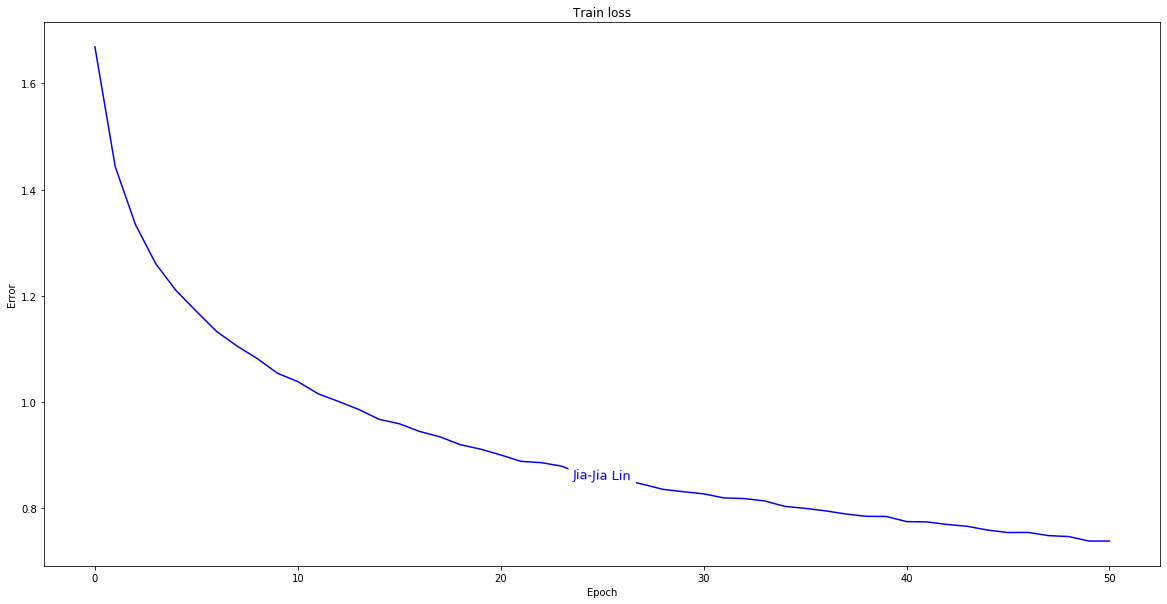

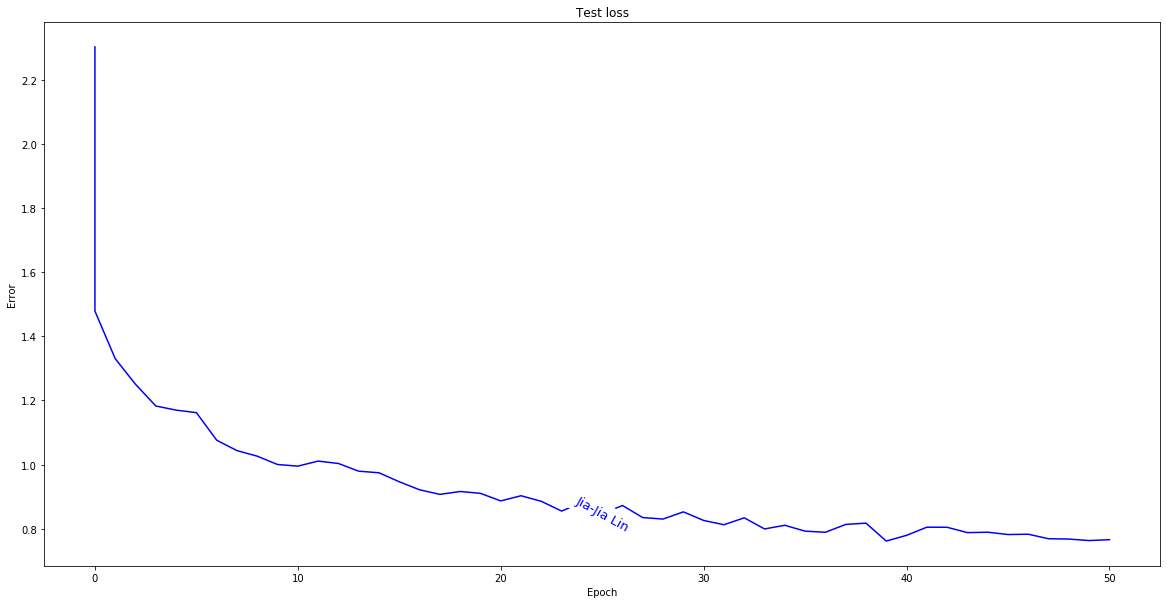

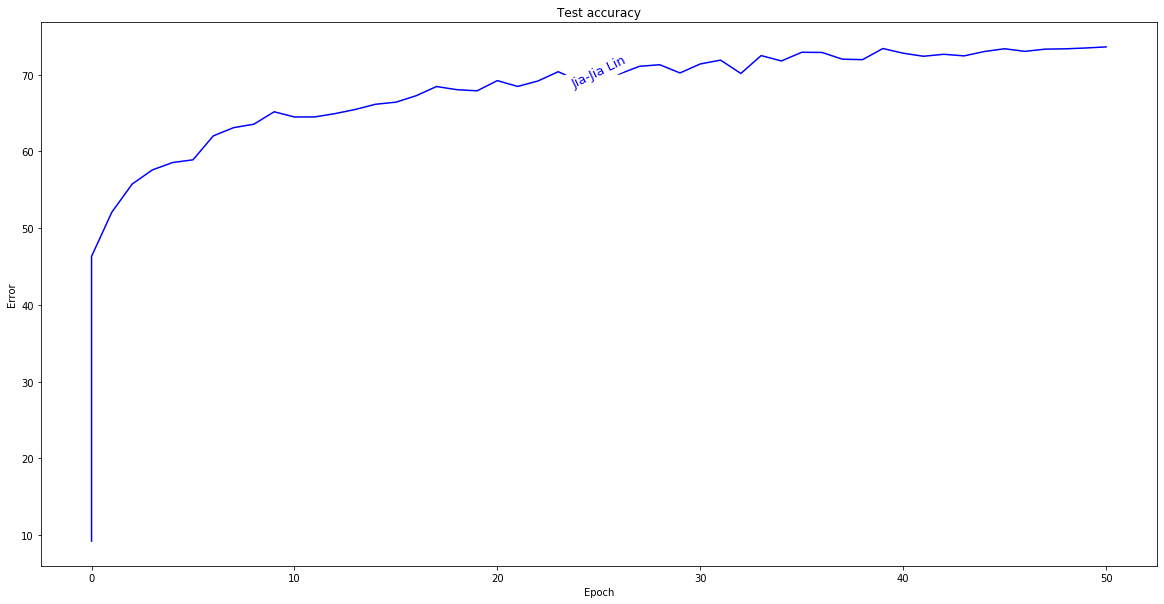

In [14]:
# Now the actual training and testing code

import multiprocessing
import traceback

# Play around with these constants, you may find a better setting.
BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005
LOG_PATH = DATA_PATH + 'log.pkl'

# handle GPU connection and multiprocessing
use_cuda = USE_CUDA and torch.cuda.is_available()
torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# iterator over the data
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE, shuffle=False, **kwargs)
# print("HI")
# print(len(test_loader))

# Initialize network and send it to GPU
model = CifarNet().to(device)
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# This will train from scratch
start_epoch = 0 
train_losses, test_losses, test_accuracies = [], [], []

# To resume training from last saved model, uncomment the following 2 lines
# start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
# train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))

# Get the initial test losses and accuracies
test_loss, test_accuracy = test(model, device, test_loader)
test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        print("hellp")
        # train the model for 1 epoch
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        print("foo", train_loss)
        train_losses.append((epoch, train_loss))
        # test the model after 1 epoch
        test_loss, test_accuracy = test(model, device, test_loader)
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        # Log the losses and accuracy
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        # save the current model in the checkpoints folder
        model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/cifar_%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(DATA_PATH + 'checkpoints/cifar_%03d.pt' % epoch, 0)
    # Plot the loss and accuracy values over epochs
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error', name)
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error', name)
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error', name)


# 1.4 Attempt to use your own test data

Download 5 images for each of the 4 classes given below. Choose the images randomly from Google, but make sure they look somewhat similar to the training data of CIFAR-10 in terms of content. For example, full body image of a dog with minimal background is recommended. Edit the text below to write down the links of the images (**NOTE**: The TAs will be evaluating YOUR network weights with YOUR chosen images, so do not collaborate with others regarding image choices.)

Plane:

- https://www.telegraph.co.uk/content/dam/Travel/2018/January/white-plane-sky.jpg?imwidth=450
- https://www.traveller.com.au/content/dam/images/h/1/9/m/g/3/image.related.articleLeadwide.620x349.h1aa81.png/1548048327915.jpg
- https://e3.365dm.com/19/10/2048x1152/skynews-plane-anonymous_4804134.jpg
- https://static.independent.co.uk/s3fs-public/thumbnails/image/2017/03/23/17/electricplane.jpg?w968h681
- https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/12/931/524/DeltaFlightIstockBoeing767.jpg?ve=1&tl=1

Car:

- https://www.extremetech.com/wp-content/uploads/2019/12/SONATA-hero-option1-764A5360-edit-640x354.jpg
- https://media.wired.com/photos/5d09594a62bcb0c9752779d9/master/pass/Transpo_G70_TA-518126.jpg
- https://article.images.consumerreports.org/f_auto/prod/content/dam/CRO%20Images%202018/Cars/November/CR-Cars-InlineHero-2019-Honda-Insight-driving-trees-11-18
- https://cdn0.tnwcdn.com/wp-content/blogs.dir/1/files/2020/01/sony-car-796x418.jpg
- https://cdn0.tnwcdn.com/wp-content/blogs.dir/1/files/2020/01/sony-car-796x418.jpg

Dog:

- https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/09/dog-landing-hero-lg.jpg?bust=1536935129&width=1080
- https://www.thesprucepets.com/thmb/8TWtyJq0RXAlWoJKu62mm4dlYdI=/960x0/filters:no_upscale():max_bytes(150000):strip_icc()/portrait-if-a-spitz-pomeranian_t20_v3o29E-5ae9bbdca18d9e0037d95983.jpg
- https://www.guidedogs.org/wp-content/uploads/2019/11/website-donate-mobile.jpg
- https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQBPYq3TKOgt6Ffw_fLT4cHlXdufByru9_u_z3aKlC_JLsj3-Xb
- https://cdn.newzealandnow.govt.nz/files/images/resources/Dog.jpg

Horse:

- https://www.thesprucepets.com/thmb/KYaXBSM013GnZ2jEZJnX4a9oIsU=/3865x2174/smart/filters:no_upscale()/horse-galloping-in-grass-688899769-587673275f9b584db3a44cdf.jpg
- https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/12/931/524/horse.jpg?ve=1&tl=1
- https://blogs.gartner.com/debbie_wilson/files/2019/10/horse.jpg
- https://mastersonmethod.com/wp-content/uploads/2019/08/biomechanics-course-image-002-1.jpg
- https://horsej-intellectsolutio.netdna-ssl.com/cdn/farfuture/SVD1oaF2ITMncqEBjp-F4wIPN3Iqw8M25m7mvjCT1-Q/mtime:1543626961/files/styles/article_large/public/pictures-videos/blogs/shutterstock_250751620_-_grigorita_ko_-_web.jpg?itok=dr2UJXfv

Now upload these images in the 'cifar10' folder in your drive. Then write a function show_images() to plot the images in a 4 x 5 grid using matplotlib. Functions to use among others:

- plt.subplot() or fig.add_subplot()
- plt.imshow() or ax.imshow()
- plt.axis('off') or ax.set_axis_off()
- plt.show()
- Image.open() from PIL (convert to numpy array before use in imshow) 

Once done, right click on the grid and click 'Save Image As'. Put the image in your report on a page (titled **External Images**).

# EXTRA CREDIT (20 points)
Use these images as the test set and check the accuracy of your trained model on this custom test set. A useful article: https://towardsdatascience.com/building-efficient-custom-datasets-in-pytorch-2563b946fd9f


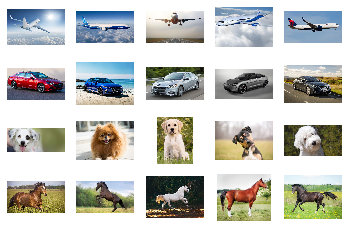

In [78]:
# TODO : image visualization; you can modify anything here
from PIL import Image

fig, axis = plt.subplots(4, 5) # 4 rows, 5 columns
DATA_PATH = BASE_PATH + 'cifar10/'

def show_images():
  for i in range(5):
    path = DATA_PATH + "plane" + str(i+1) + ".jpg"
    img = Image.open(path)
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    # plt.show()
    
  for i in range(5):
    path = DATA_PATH + "car" + str(i+1) + ".jpg"
    img = Image.open(path)
    plt.subplot(4, 5, i+6)
    plt.imshow(img)
    plt.axis('off')
    # plt.show()
  
  for i in range(5):
    path = DATA_PATH + "dog" + str(i+1) + ".jpg"
    img = Image.open(path)
    plt.subplot(4, 5, i+11)
    plt.imshow(img)
    plt.axis('off')
    # plt.show()
  
  for i in range(5):
    path = DATA_PATH + "horse" + str(i+1) + ".jpg"
    img = Image.open(path)
    plt.subplot(4, 5, i+16)
    plt.imshow(img)
    plt.axis('off')
    # plt.show()

  plt.show()

show_images()

# EXTRA CREDIT CODE HERE (IF ANY)


# Part 2: Language generation using character-level RNNs

# 2.1 Processing the data

We'll be using the complete text of Harry Potter as our corpus. Place the harry_potter.txt file provided in the 'language' folder created in your drive.

1) Create a dictionary voc2ind to define the vocabulary. voc2ind contents will be like `{' ': 0, 'A': 1, 'B': 2, 'C': 3, ... '0': 35, '1': 36, ..., '$': 78, '#': 79, '(': 80, ...}`. The keys include all the 26 alphabets, both upper case and lower case separately, digits 0-9 and special characters that may appear in a general text. The values corresponding to the keys can be in any order. You may have to handle single and double quotes carefully in the keys since they are generally used as string delimiters. ind2voc is the inverse of voc2ind.

2) Now using the vocabulary above, convert text into a list of tokens. For example, if the text is **`"ABA CDBE"`**, the token version will be a list with contents `[1, 2, 1, 0, 3, 4, 2, 5]`. Create this list where instructed below.

3) train_text and test_text should contain the first 80% and the last 20% of the 'token' list. This should be simple to write.


In [5]:
import string # I added this

DATA_PATH = BASE_PATH + 'language/'
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TO DO: done
    voc2ind = dict([(chr(i+32),i) for i in range(0,95)])
    
    # transform the data into an integer representation of the tokens.
    token = []
    for char in data:
        # replaces all weird spacing like tab, next line etc. with space
        if re.match('\s+', char): char = ' '
        # TO DO: done (create the list of tokens; basically replace None with the correct expression)
        token.append(voc2ind[char])

    ind2voc = {val: key for key, val in voc2ind.items()}

    # TO DO: done
    # for i in range(10):
    #   print(token[i])
    train_text = token[0:int(0.80*len(token) + 1)]
    #print(train_text)
    test_text = token[int(0.80*len(token)) + 1:len(token)]
    #print(test_text)

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    # the above data should be in language
    print('Data prepared!')
    
prepare_data(DATA_PATH + 'harry_potter.txt')

class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

Data prepared!


Now we have to load the data. There's nothing to do here on your part, but this is an explanation of what is going on. First imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, we should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is 2 and the sequence length is 4
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Note:
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- The last label in one batch is the first data in the next batch.

In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # make dataset length a multiple of batch size
        # removing the last bit to make the data the proper shape mostly gives better results than padding with 0s.
        new_dataset_length = (len(dataset['tokens'])//self.batch_size) * self.batch_size        
        self.tokens = dataset['tokens'][:new_dataset_length]

        self.chunk_size = int(new_dataset_length / self.batch_size)

    def __len__(self):
        # return the number of unique sequences you have, not the number of characters.
        return self.batch_size * int(np.ceil((self.chunk_size-1)/self.sequence_length))
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence
        # Return a single entry for the batch using the idx to decide which chunk you are in and how far down in the chunk you are.
        chunk_idx = idx % self.batch_size
        pos_idx = idx // self.batch_size

        start_idx = self.chunk_size * chunk_idx + self.sequence_length * pos_idx
        end_idx = self.chunk_size * chunk_idx + min(self.sequence_length * pos_idx + self.sequence_length + 1, self.chunk_size)

        data = self.tokens[start_idx : end_idx]
        # The data and labels should be torch long tensors.
        return torch.LongTensor(data[:-1]), torch.LongTensor(data[1:])

    def vocab_size(self):
        return len(self.vocab)

# 2.2 Defining the network

The network, a generic RNN is defined below for you. Just replace the GRU layer with an LSTM layer. You can look up LSTM definition in Pytorch online. Then, implement the forward pass as instructed.

In [0]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        # TO DO: done (replace the following line with LSTM layer)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TO DO: done
        # pass x though the encoder first, then through LSTM, then through the decoder.
        # return items from LSTM layer should be both the output and the hidden state.
        x = self.encoder(x)
        x, hidden_state = self.lstm(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

# 2.3 Character generation and training

You don't have to write any code in this part. Just understand how the steps work. The training and testing functions and the main function are quite similar to the ones in Part 1. Here is an interesting article about sampling strategies (we have used max sampling strategy here for convenience):
https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277

Feel free to modify various portions of the code to understand better, and refer to online resources. Natural Language Processing details are beyond the scope of this course.

At the end, save the 3 plots (train loss, test loss and test accuracy) as before and put them in your report on a single page (titled **NLP plots**). In addition, write down (in your report) the generated sentence that will be displayed at the end. You will also need to submit 'language_020.pt' file from 'checkpoints' folder in your 'language' folder.


In [0]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10
import tqdm

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)
    

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    ind = torch.argmax(output)
    for ii in range(sequence_length):
        output, hidden = model.inference(ind, hidden, TEMPERATURE)
        ind = torch.argmax(output)
        outputs.append(ind)
    return outputs

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)
        return vocab.array_to_words(seed_words_arr.tolist() + outputs)
    

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        # send data and label to GPU
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches.
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
               
        optimizer.zero_grad()
        # run the model and get the prediction
        output, hidden = model(data)
        pred = output.max(-1)[1]
        
        # compute and backpropagate the loss
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    print(len(test_loader))
    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            # send data and label to GPU
            data, label = data.to(device), label.to(device)
            
            # test the model
            output, hidden = model(data, hidden)
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            
            # compute test loss
            test_loss += model.loss(output, label, reduction='mean').item()
            
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy


Using device cuda
num workers: 2
TESTING: 
49
49
Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	%tmZJbmZm?J8ZZaZJJ8ZJb,,f'J JCDPaaJJ{7Ha8GQ8ZJ}DZom`Q%aaZJZZXaZcvvZQ,ZJF\9l9JJ)Xat+JGaafZZaZZ'JZJJlJ


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	ZZ'},ZJ}DZ'JXZbQVxZ9ZZZ8ta,XaaZ'J)JJJb7m69l9mDDDudQ:ZJ9ZaZZ'JZJb,afZJJZJZbZbom,XrKKJJJXXQ}yBytDZZaZJ


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	,}'JbQDZJJXZJJa8ZmaJ8ZZ'JZJfGPaaZbXb5'JmZmZJZaaZJJ)ZbbDZZJll%ZZaZDDQQ$ZJJ)JJbmDJmmmDQDZXPQ8tmmJmD

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 8.5732, Accuracy: 10099/1254400 (1%)



  2%|▏         | 3/196 [00:00<00:32,  5.90it/s]

Train Epoch: 0 [0/50176 (0%)]	Loss: 8.543026


  7%|▋         | 13/196 [00:01<00:20,  9.07it/s]

Train Epoch: 0 [2560/50176 (5%)]	Loss: 4.743855


 12%|█▏        | 23/196 [00:02<00:17, 10.03it/s]

Train Epoch: 0 [5120/50176 (10%)]	Loss: 2.983315


 17%|█▋        | 33/196 [00:03<00:15, 10.22it/s]

Train Epoch: 0 [7680/50176 (15%)]	Loss: 2.454858


 21%|██        | 41/196 [00:04<00:15, 10.13it/s]

Train Epoch: 0 [10240/50176 (20%)]	Loss: 2.255984


 27%|██▋       | 53/196 [00:05<00:14, 10.16it/s]

Train Epoch: 0 [12800/50176 (26%)]	Loss: 2.149830


 32%|███▏      | 63/196 [00:06<00:13, 10.13it/s]

Train Epoch: 0 [15360/50176 (31%)]	Loss: 2.041620


 36%|███▌      | 71/196 [00:07<00:12, 10.13it/s]

Train Epoch: 0 [17920/50176 (36%)]	Loss: 1.999888


 41%|████▏     | 81/196 [00:08<00:11, 10.08it/s]

Train Epoch: 0 [20480/50176 (41%)]	Loss: 1.923406


 46%|████▋     | 91/196 [00:09<00:10, 10.08it/s]

Train Epoch: 0 [23040/50176 (46%)]	Loss: 1.878955


 52%|█████▏    | 102/196 [00:10<00:09,  9.90it/s]

Train Epoch: 0 [25600/50176 (51%)]	Loss: 1.872288


 57%|█████▋    | 112/196 [00:11<00:08,  9.85it/s]

Train Epoch: 0 [28160/50176 (56%)]	Loss: 1.855311


 62%|██████▏   | 122/196 [00:12<00:07,  9.84it/s]

Train Epoch: 0 [30720/50176 (61%)]	Loss: 1.818599


 67%|██████▋   | 131/196 [00:13<00:06,  9.76it/s]

Train Epoch: 0 [33280/50176 (66%)]	Loss: 1.781145


 72%|███████▏  | 142/196 [00:14<00:05,  9.84it/s]

Train Epoch: 0 [35840/50176 (71%)]	Loss: 1.777640


 78%|███████▊  | 152/196 [00:15<00:04,  9.79it/s]

Train Epoch: 0 [38400/50176 (77%)]	Loss: 1.747044


 83%|████████▎ | 162/196 [00:16<00:03,  9.84it/s]

Train Epoch: 0 [40960/50176 (82%)]	Loss: 1.754884


 88%|████████▊ | 172/196 [00:17<00:02,  9.83it/s]

Train Epoch: 0 [43520/50176 (87%)]	Loss: 1.714011


 93%|█████████▎| 182/196 [00:18<00:01,  9.85it/s]

Train Epoch: 0 [46080/50176 (92%)]	Loss: 1.724856


 97%|█████████▋| 191/196 [00:19<00:00,  9.81it/s]

Train Epoch: 0 [48640/50176 (97%)]	Loss: 1.708467


100%|██████████| 196/196 [00:19<00:00,  9.97it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	ey tas woat th tet tascr  au ause tolderort oid buacted tn whmt .  e woong tis elf tfer th the cvger


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	thet tid bis wne  "  weai rs  tis  aocl ng teck ard tn o the cascr tath t lteecte te struceeedoth ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	he wnd tis wiet tott the sreund tn the  wokter tim and teean th tonei aas  ahiw y tnd ttrp f  auck o


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.6987, Accuracy: 633120/1254400 (50%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_000.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I was the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started the started th



  1%|          | 2/196 [00:00<00:29,  6.64it/s]

Train Epoch: 1 [0/50176 (0%)]	Loss: 1.694130


  6%|▌         | 12/196 [00:01<00:19,  9.39it/s]

Train Epoch: 1 [2560/50176 (5%)]	Loss: 1.655800


 11%|█         | 22/196 [00:02<00:17,  9.77it/s]

Train Epoch: 1 [5120/50176 (10%)]	Loss: 1.679929


 16%|█▋        | 32/196 [00:03<00:16,  9.87it/s]

Train Epoch: 1 [7680/50176 (15%)]	Loss: 1.658068


 21%|██▏       | 42/196 [00:04<00:15,  9.85it/s]

Train Epoch: 1 [10240/50176 (20%)]	Loss: 1.632177


 27%|██▋       | 52/196 [00:05<00:14,  9.83it/s]

Train Epoch: 1 [12800/50176 (26%)]	Loss: 1.637118


 32%|███▏      | 62/196 [00:06<00:13,  9.88it/s]

Train Epoch: 1 [15360/50176 (31%)]	Loss: 1.623380


 37%|███▋      | 72/196 [00:07<00:12,  9.84it/s]

Train Epoch: 1 [17920/50176 (36%)]	Loss: 1.632939


 42%|████▏     | 82/196 [00:08<00:11,  9.83it/s]

Train Epoch: 1 [20480/50176 (41%)]	Loss: 1.601161


 47%|████▋     | 92/196 [00:09<00:10,  9.83it/s]

Train Epoch: 1 [23040/50176 (46%)]	Loss: 1.585089


 52%|█████▏    | 101/196 [00:10<00:09,  9.80it/s]

Train Epoch: 1 [25600/50176 (51%)]	Loss: 1.594699


 57%|█████▋    | 111/196 [00:11<00:08,  9.81it/s]

Train Epoch: 1 [28160/50176 (56%)]	Loss: 1.593286


 62%|██████▏   | 122/196 [00:12<00:07,  9.57it/s]

Train Epoch: 1 [30720/50176 (61%)]	Loss: 1.574735


 67%|██████▋   | 132/196 [00:13<00:06,  9.85it/s]

Train Epoch: 1 [33280/50176 (66%)]	Loss: 1.556735


 72%|███████▏  | 142/196 [00:14<00:05,  9.58it/s]

Train Epoch: 1 [35840/50176 (71%)]	Loss: 1.563182


 78%|███████▊  | 152/196 [00:15<00:04,  9.79it/s]

Train Epoch: 1 [38400/50176 (77%)]	Loss: 1.550572


 83%|████████▎ | 162/196 [00:16<00:03,  9.79it/s]

Train Epoch: 1 [40960/50176 (82%)]	Loss: 1.574171


 88%|████████▊ | 172/196 [00:17<00:02,  9.81it/s]

Train Epoch: 1 [43520/50176 (87%)]	Loss: 1.539649


 93%|█████████▎| 182/196 [00:18<00:01,  9.76it/s]

Train Epoch: 1 [46080/50176 (92%)]	Loss: 1.562332


 98%|█████████▊| 192/196 [00:19<00:00,  9.58it/s]

Train Epoch: 1 [48640/50176 (97%)]	Loss: 1.551616


100%|██████████| 196/196 [00:20<00:00,  9.78it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	dy tis toat th tet thscr  tu ause toldemort ted teacded tt wemt . .e woong tem elf tfer th the cxges


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	thet ted bem fno  "t wealsse  tim  tocleng teck ard tt o the tiscr tith t steayte he hthebeeed th ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd tes faet titt the creund tn the  wokt d tim tnd te an th tonri aam  ttiwly tnd ttre y  tuck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.5619, Accuracy: 677309/1254400 (54%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_001.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. I the could he was the could he was the could he was the could he was the could he was the could he was the could he was the could he was the could he was the could he was the could he was the could h



  1%|          | 2/196 [00:00<00:29,  6.49it/s]

Train Epoch: 2 [0/50176 (0%)]	Loss: 1.549703


  6%|▌         | 12/196 [00:01<00:19,  9.42it/s]

Train Epoch: 2 [2560/50176 (5%)]	Loss: 1.519012


 11%|█         | 22/196 [00:02<00:18,  9.62it/s]

Train Epoch: 2 [5120/50176 (10%)]	Loss: 1.546042


 16%|█▋        | 32/196 [00:03<00:17,  9.50it/s]

Train Epoch: 2 [7680/50176 (15%)]	Loss: 1.518416


 21%|██▏       | 42/196 [00:04<00:16,  9.48it/s]

Train Epoch: 2 [10240/50176 (20%)]	Loss: 1.511984


 27%|██▋       | 52/196 [00:05<00:15,  9.50it/s]

Train Epoch: 2 [12800/50176 (26%)]	Loss: 1.511783


 32%|███▏      | 62/196 [00:06<00:14,  9.37it/s]

Train Epoch: 2 [15360/50176 (31%)]	Loss: 1.516181


 37%|███▋      | 72/196 [00:07<00:13,  9.41it/s]

Train Epoch: 2 [17920/50176 (36%)]	Loss: 1.538168


 42%|████▏     | 82/196 [00:08<00:12,  9.41it/s]

Train Epoch: 2 [20480/50176 (41%)]	Loss: 1.496694


 47%|████▋     | 92/196 [00:09<00:11,  9.38it/s]

Train Epoch: 2 [23040/50176 (46%)]	Loss: 1.488352


 52%|█████▏    | 102/196 [00:10<00:10,  9.36it/s]

Train Epoch: 2 [25600/50176 (51%)]	Loss: 1.496855


 57%|█████▋    | 112/196 [00:11<00:08,  9.42it/s]

Train Epoch: 2 [28160/50176 (56%)]	Loss: 1.496012


 62%|██████▏   | 122/196 [00:12<00:07,  9.35it/s]

Train Epoch: 2 [30720/50176 (61%)]	Loss: 1.488179


 67%|██████▋   | 132/196 [00:13<00:06,  9.44it/s]

Train Epoch: 2 [33280/50176 (66%)]	Loss: 1.469405


 72%|███████▏  | 142/196 [00:14<00:05,  9.43it/s]

Train Epoch: 2 [35840/50176 (71%)]	Loss: 1.479735


 78%|███████▊  | 152/196 [00:16<00:04,  9.30it/s]

Train Epoch: 2 [38400/50176 (77%)]	Loss: 1.474073


 83%|████████▎ | 162/196 [00:17<00:03,  9.19it/s]

Train Epoch: 2 [40960/50176 (82%)]	Loss: 1.501811


 88%|████████▊ | 172/196 [00:18<00:02,  9.32it/s]

Train Epoch: 2 [43520/50176 (87%)]	Loss: 1.476112


 93%|█████████▎| 182/196 [00:19<00:01,  9.06it/s]

Train Epoch: 2 [46080/50176 (92%)]	Loss: 1.538350


 98%|█████████▊| 192/196 [00:20<00:00,  9.13it/s]

Train Epoch: 2 [48640/50176 (97%)]	Loss: 1.503814


100%|██████████| 196/196 [00:20<00:00,  9.42it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	ey tas toat th tet tascr. tu ause toldemort wad toaneed tn womt . .a woong ois elf tfer th the fnges


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	woat ted tas fno  "t wealdle  tis  tocleng aack ard tn o the falcr.tath ansteayhe he hahameled to ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd tes faet aoft the fround tn the  wokt d tim tnd te an to tonri aas  aoowly and thrp y  tuck o


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.5107, Accuracy: 696224/1254400 (56%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_002.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. What was staring to the for the find of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the 



  1%|          | 2/196 [00:00<00:30,  6.38it/s]

Train Epoch: 3 [0/50176 (0%)]	Loss: 1.499276


  6%|▌         | 12/196 [00:01<00:20,  8.91it/s]

Train Epoch: 3 [2560/50176 (5%)]	Loss: 1.458188


 11%|█         | 22/196 [00:02<00:19,  9.11it/s]

Train Epoch: 3 [5120/50176 (10%)]	Loss: 1.487007


 16%|█▋        | 32/196 [00:03<00:18,  9.00it/s]

Train Epoch: 3 [7680/50176 (15%)]	Loss: 1.460182


 21%|██▏       | 42/196 [00:04<00:17,  9.04it/s]

Train Epoch: 3 [10240/50176 (20%)]	Loss: 1.449699


 27%|██▋       | 52/196 [00:05<00:15,  9.14it/s]

Train Epoch: 3 [12800/50176 (26%)]	Loss: 1.459317


 32%|███▏      | 62/196 [00:06<00:14,  9.14it/s]

Train Epoch: 3 [15360/50176 (31%)]	Loss: 1.463615


 37%|███▋      | 72/196 [00:08<00:13,  9.23it/s]

Train Epoch: 3 [17920/50176 (36%)]	Loss: 1.462279


 42%|████▏     | 82/196 [00:09<00:12,  9.08it/s]

Train Epoch: 3 [20480/50176 (41%)]	Loss: 1.439479


 47%|████▋     | 92/196 [00:10<00:11,  9.26it/s]

Train Epoch: 3 [23040/50176 (46%)]	Loss: 1.443110


 52%|█████▏    | 102/196 [00:11<00:10,  9.18it/s]

Train Epoch: 3 [25600/50176 (51%)]	Loss: 1.455999


 57%|█████▋    | 112/196 [00:12<00:09,  9.03it/s]

Train Epoch: 3 [28160/50176 (56%)]	Loss: 1.456933


 62%|██████▏   | 122/196 [00:13<00:08,  9.05it/s]

Train Epoch: 3 [30720/50176 (61%)]	Loss: 1.449320


 67%|██████▋   | 132/196 [00:14<00:06,  9.19it/s]

Train Epoch: 3 [33280/50176 (66%)]	Loss: 1.448488


 72%|███████▏  | 142/196 [00:15<00:05,  9.12it/s]

Train Epoch: 3 [35840/50176 (71%)]	Loss: 1.439264


 78%|███████▊  | 152/196 [00:16<00:04,  9.29it/s]

Train Epoch: 3 [38400/50176 (77%)]	Loss: 1.431561


 83%|████████▎ | 162/196 [00:17<00:03,  9.37it/s]

Train Epoch: 3 [40960/50176 (82%)]	Loss: 1.460443


 88%|████████▊ | 172/196 [00:18<00:02,  9.39it/s]

Train Epoch: 3 [43520/50176 (87%)]	Loss: 1.424048


 93%|█████████▎| 182/196 [00:19<00:01,  9.45it/s]

Train Epoch: 3 [46080/50176 (92%)]	Loss: 1.457136


 98%|█████████▊| 192/196 [00:21<00:00,  9.31it/s]

Train Epoch: 3 [48640/50176 (97%)]	Loss: 1.450784


100%|██████████| 196/196 [00:21<00:00,  9.16it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	dy tas toat th tet thscr. tucause toldemort wad tuayeed tn womt ...e woong ois elf tfer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	woat ted tem fnms "t wealaled tim  tocleng teck ard tnto the calcr.tith a ltiinhe he wahameled to ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd tes faet aiat the dround tn the  wokted tim tnd teean to tonei.aams toiwly and ttrp y  tuck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.4616, Accuracy: 709052/1254400 (57%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_003.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Well, the door that was the door that was the door that was the door that was the door that was the door that was the door that was the door that was the door that was the door that was the door that 



  1%|          | 2/196 [00:00<00:29,  6.64it/s]

Train Epoch: 4 [0/50176 (0%)]	Loss: 1.450170


  6%|▌         | 12/196 [00:01<00:19,  9.25it/s]

Train Epoch: 4 [2560/50176 (5%)]	Loss: 1.410549


 11%|█         | 22/196 [00:02<00:18,  9.43it/s]

Train Epoch: 4 [5120/50176 (10%)]	Loss: 1.447490


 16%|█▋        | 32/196 [00:03<00:17,  9.40it/s]

Train Epoch: 4 [7680/50176 (15%)]	Loss: 1.430070


 21%|██▏       | 42/196 [00:04<00:16,  9.34it/s]

Train Epoch: 4 [10240/50176 (20%)]	Loss: 1.423193


 27%|██▋       | 52/196 [00:05<00:15,  9.32it/s]

Train Epoch: 4 [12800/50176 (26%)]	Loss: 1.420508


 32%|███▏      | 62/196 [00:06<00:14,  9.37it/s]

Train Epoch: 4 [15360/50176 (31%)]	Loss: 1.429486


 37%|███▋      | 72/196 [00:07<00:13,  9.36it/s]

Train Epoch: 4 [17920/50176 (36%)]	Loss: 1.433878


 42%|████▏     | 82/196 [00:08<00:12,  9.31it/s]

Train Epoch: 4 [20480/50176 (41%)]	Loss: 1.407487


 47%|████▋     | 92/196 [00:09<00:10,  9.61it/s]

Train Epoch: 4 [23040/50176 (46%)]	Loss: 1.417363


 52%|█████▏    | 102/196 [00:10<00:09,  9.61it/s]

Train Epoch: 4 [25600/50176 (51%)]	Loss: 1.424439


 57%|█████▋    | 112/196 [00:11<00:08,  9.56it/s]

Train Epoch: 4 [28160/50176 (56%)]	Loss: 1.428510


 62%|██████▏   | 122/196 [00:12<00:07,  9.59it/s]

Train Epoch: 4 [30720/50176 (61%)]	Loss: 1.411835


 67%|██████▋   | 132/196 [00:13<00:06,  9.54it/s]

Train Epoch: 4 [33280/50176 (66%)]	Loss: 1.405272


 72%|███████▏  | 142/196 [00:14<00:05,  9.71it/s]

Train Epoch: 4 [35840/50176 (71%)]	Loss: 1.441598


 78%|███████▊  | 152/196 [00:16<00:04,  9.81it/s]

Train Epoch: 4 [38400/50176 (77%)]	Loss: 1.415048


 83%|████████▎ | 162/196 [00:17<00:03,  9.74it/s]

Train Epoch: 4 [40960/50176 (82%)]	Loss: 1.437566


 87%|████████▋ | 171/196 [00:17<00:02,  9.64it/s]

Train Epoch: 4 [43520/50176 (87%)]	Loss: 1.398263


 93%|█████████▎| 182/196 [00:19<00:01,  9.74it/s]

Train Epoch: 4 [46080/50176 (92%)]	Loss: 1.426394


 98%|█████████▊| 192/196 [00:20<00:00,  9.59it/s]

Train Epoch: 4 [48640/50176 (97%)]	Loss: 1.427363


100%|██████████| 196/196 [00:20<00:00,  9.55it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	dy tas toat th tet thscr. aucause toldemort wad tueyeed tn iomt . .e weong oimself afer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	woat hed bas hnms "t weaeased tim  aocleng aeck ard tnto the calcr.tath a stiinhe he hahameled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and tes faet aiat the dround on the  wokeed timsand teean to tonri.aams ahiwly.atd ttrp y  auck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.4323, Accuracy: 717763/1254400 (57%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_004.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Well, the stand and the door of the door of the courtains of the courtains of the courtains of the courtains of the courtains of the counters of the counters of the counters of the counters of the cou



  1%|          | 2/196 [00:00<00:29,  6.60it/s]

Train Epoch: 5 [0/50176 (0%)]	Loss: 1.423566


  6%|▌         | 12/196 [00:01<00:19,  9.33it/s]

Train Epoch: 5 [2560/50176 (5%)]	Loss: 1.389753


 11%|█         | 22/196 [00:02<00:17,  9.69it/s]

Train Epoch: 5 [5120/50176 (10%)]	Loss: 1.430504


 16%|█▋        | 32/196 [00:03<00:16,  9.80it/s]

Train Epoch: 5 [7680/50176 (15%)]	Loss: 1.408688


 21%|██▏       | 42/196 [00:04<00:15,  9.77it/s]

Train Epoch: 5 [10240/50176 (20%)]	Loss: 1.413316


 27%|██▋       | 52/196 [00:05<00:14,  9.78it/s]

Train Epoch: 5 [12800/50176 (26%)]	Loss: 1.424444


 32%|███▏      | 62/196 [00:06<00:13,  9.73it/s]

Train Epoch: 5 [15360/50176 (31%)]	Loss: 1.417494


 37%|███▋      | 72/196 [00:07<00:12,  9.77it/s]

Train Epoch: 5 [17920/50176 (36%)]	Loss: 1.423203


 42%|████▏     | 82/196 [00:08<00:11,  9.69it/s]

Train Epoch: 5 [20480/50176 (41%)]	Loss: 1.388881


 47%|████▋     | 92/196 [00:09<00:10,  9.59it/s]

Train Epoch: 5 [23040/50176 (46%)]	Loss: 1.394580


 52%|█████▏    | 102/196 [00:10<00:09,  9.77it/s]

Train Epoch: 5 [25600/50176 (51%)]	Loss: 1.413032


 57%|█████▋    | 112/196 [00:11<00:08,  9.74it/s]

Train Epoch: 5 [28160/50176 (56%)]	Loss: 1.405962


 62%|██████▏   | 122/196 [00:12<00:07,  9.54it/s]

Train Epoch: 5 [30720/50176 (61%)]	Loss: 1.435707


 67%|██████▋   | 132/196 [00:13<00:06,  9.80it/s]

Train Epoch: 5 [33280/50176 (66%)]	Loss: 1.429438


 72%|███████▏  | 142/196 [00:14<00:05,  9.67it/s]

Train Epoch: 5 [35840/50176 (71%)]	Loss: 1.409707


 78%|███████▊  | 152/196 [00:15<00:04,  9.82it/s]

Train Epoch: 5 [38400/50176 (77%)]	Loss: 1.392930


 83%|████████▎ | 162/196 [00:16<00:03,  9.56it/s]

Train Epoch: 5 [40960/50176 (82%)]	Loss: 1.416402


 88%|████████▊ | 172/196 [00:17<00:02,  9.68it/s]

Train Epoch: 5 [43520/50176 (87%)]	Loss: 1.383956


 93%|█████████▎| 182/196 [00:18<00:01,  9.72it/s]

Train Epoch: 5 [46080/50176 (92%)]	Loss: 1.411087


 98%|█████████▊| 192/196 [00:19<00:00,  9.72it/s]

Train Epoch: 5 [48640/50176 (97%)]	Loss: 1.407938


100%|██████████| 196/196 [00:20<00:00,  9.67it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	gy tas tiat th tet thscr  aucause holdemort wad tuaneed tn iomt . .e woing oim elf afer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	woat hed aas fnms "t weaeased tim  aocling aack ard anto the calcr.aath a lhiinhe he hahameled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd tes faet aiat the dround on the  wokeed timsand teaan to torriiaams ahiwly.atd ttrp y  auck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.4126, Accuracy: 725731/1254400 (58%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_005.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. What is it," said Harry. "I don't think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think you think 



  1%|          | 2/196 [00:00<00:30,  6.44it/s]

Train Epoch: 6 [0/50176 (0%)]	Loss: 1.406090


  6%|▌         | 12/196 [00:01<00:19,  9.47it/s]

Train Epoch: 6 [2560/50176 (5%)]	Loss: 1.376849


 11%|█         | 22/196 [00:02<00:18,  9.35it/s]

Train Epoch: 6 [5120/50176 (10%)]	Loss: 1.414480


 16%|█▋        | 32/196 [00:03<00:17,  9.47it/s]

Train Epoch: 6 [7680/50176 (15%)]	Loss: 1.388406


 21%|██▏       | 42/196 [00:04<00:16,  9.62it/s]

Train Epoch: 6 [10240/50176 (20%)]	Loss: 1.380887


 27%|██▋       | 52/196 [00:05<00:15,  9.49it/s]

Train Epoch: 6 [12800/50176 (26%)]	Loss: 1.384084


 32%|███▏      | 62/196 [00:06<00:14,  9.53it/s]

Train Epoch: 6 [15360/50176 (31%)]	Loss: 1.415431


 37%|███▋      | 72/196 [00:07<00:13,  9.54it/s]

Train Epoch: 6 [17920/50176 (36%)]	Loss: 1.410722


 42%|████▏     | 82/196 [00:08<00:11,  9.52it/s]

Train Epoch: 6 [20480/50176 (41%)]	Loss: 1.380796


 47%|████▋     | 92/196 [00:09<00:10,  9.61it/s]

Train Epoch: 6 [23040/50176 (46%)]	Loss: 1.401153


 52%|█████▏    | 102/196 [00:10<00:09,  9.51it/s]

Train Epoch: 6 [25600/50176 (51%)]	Loss: 1.400205


 57%|█████▋    | 112/196 [00:11<00:08,  9.57it/s]

Train Epoch: 6 [28160/50176 (56%)]	Loss: 1.395158


 62%|██████▏   | 122/196 [00:12<00:07,  9.51it/s]

Train Epoch: 6 [30720/50176 (61%)]	Loss: 1.399286


 67%|██████▋   | 132/196 [00:13<00:06,  9.50it/s]

Train Epoch: 6 [33280/50176 (66%)]	Loss: 1.418599


 72%|███████▏  | 142/196 [00:14<00:05,  9.47it/s]

Train Epoch: 6 [35840/50176 (71%)]	Loss: 1.407797


 78%|███████▊  | 152/196 [00:15<00:04,  9.45it/s]

Train Epoch: 6 [38400/50176 (77%)]	Loss: 1.378229


 83%|████████▎ | 162/196 [00:17<00:03,  9.38it/s]

Train Epoch: 6 [40960/50176 (82%)]	Loss: 1.404758


 88%|████████▊ | 172/196 [00:18<00:02,  9.49it/s]

Train Epoch: 6 [43520/50176 (87%)]	Loss: 1.372978


 93%|█████████▎| 182/196 [00:19<00:01,  9.51it/s]

Train Epoch: 6 [46080/50176 (92%)]	Loss: 1.404498


 98%|█████████▊| 192/196 [00:20<00:00,  9.44it/s]

Train Epoch: 6 [48640/50176 (97%)]	Loss: 1.401089


100%|██████████| 196/196 [00:20<00:00,  9.51it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y tas tiat th tet thscr  aucause holdemort wad buaceed tn iomt . .e woing oim elf afer th hhe snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	woat hed bas fnm  "t weaeased tim  aocling tack ard anto the caler.aath h stiinhe he waremeled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd tes faet aoat the sround on the  wokted tim.and teaan to toteiiaims aoiwly.atd ttdp y  auck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.4106, Accuracy: 726129/1254400 (58%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_006.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. e was standing at the companted of his face. "I was still standing and the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the stair



  1%|          | 2/196 [00:00<00:29,  6.53it/s]

Train Epoch: 7 [0/50176 (0%)]	Loss: 1.404228


  6%|▌         | 12/196 [00:01<00:19,  9.25it/s]

Train Epoch: 7 [2560/50176 (5%)]	Loss: 1.371809


 11%|█         | 22/196 [00:02<00:18,  9.42it/s]

Train Epoch: 7 [5120/50176 (10%)]	Loss: 1.408036


 16%|█▋        | 32/196 [00:03<00:17,  9.51it/s]

Train Epoch: 7 [7680/50176 (15%)]	Loss: 1.380057


 21%|██▏       | 42/196 [00:04<00:16,  9.56it/s]

Train Epoch: 7 [10240/50176 (20%)]	Loss: 1.374287


 27%|██▋       | 52/196 [00:05<00:15,  9.46it/s]

Train Epoch: 7 [12800/50176 (26%)]	Loss: 1.377138


 32%|███▏      | 62/196 [00:06<00:14,  9.36it/s]

Train Epoch: 7 [15360/50176 (31%)]	Loss: 1.397460


 37%|███▋      | 72/196 [00:07<00:12,  9.55it/s]

Train Epoch: 7 [17920/50176 (36%)]	Loss: 1.402690


 42%|████▏     | 82/196 [00:08<00:12,  9.45it/s]

Train Epoch: 7 [20480/50176 (41%)]	Loss: 1.381855


 47%|████▋     | 92/196 [00:09<00:11,  9.41it/s]

Train Epoch: 7 [23040/50176 (46%)]	Loss: 1.395544


 52%|█████▏    | 102/196 [00:10<00:09,  9.62it/s]

Train Epoch: 7 [25600/50176 (51%)]	Loss: 1.403527


 57%|█████▋    | 112/196 [00:11<00:08,  9.53it/s]

Train Epoch: 7 [28160/50176 (56%)]	Loss: 1.386947


 62%|██████▏   | 122/196 [00:12<00:07,  9.46it/s]

Train Epoch: 7 [30720/50176 (61%)]	Loss: 1.383564


 67%|██████▋   | 132/196 [00:13<00:06,  9.45it/s]

Train Epoch: 7 [33280/50176 (66%)]	Loss: 1.374319


 72%|███████▏  | 142/196 [00:14<00:05,  9.61it/s]

Train Epoch: 7 [35840/50176 (71%)]	Loss: 1.380711


 78%|███████▊  | 152/196 [00:16<00:04,  9.62it/s]

Train Epoch: 7 [38400/50176 (77%)]	Loss: 1.374872


 83%|████████▎ | 162/196 [00:17<00:03,  9.53it/s]

Train Epoch: 7 [40960/50176 (82%)]	Loss: 1.404654


 88%|████████▊ | 172/196 [00:18<00:02,  9.57it/s]

Train Epoch: 7 [43520/50176 (87%)]	Loss: 1.372385


 93%|█████████▎| 182/196 [00:19<00:01,  9.62it/s]

Train Epoch: 7 [46080/50176 (92%)]	Loss: 1.398015


 98%|█████████▊| 192/196 [00:20<00:00,  9.58it/s]

Train Epoch: 7 [48640/50176 (97%)]	Loss: 1.399330


100%|██████████| 196/196 [00:20<00:00,  9.51it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y tis titt th tet tiscr  aucause toldemort wad tuaneed tn.iomt.. .e weing oim elf afer th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	woat hed aas hnm  "t weaeased tim  aocling tack ard anto the ciler.aith h stiithi ae warembled oo hi


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  tnd tes faet aiat the sround on the  wokted tim and tetan to hotei aiss aoiwly atd ttrp y  auck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3954, Accuracy: 732408/1254400 (58%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_007.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. e was still standing at the complete of his face and the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the stairs a



  1%|          | 2/196 [00:00<00:30,  6.40it/s]

Train Epoch: 8 [0/50176 (0%)]	Loss: 1.389704


  6%|▌         | 12/196 [00:01<00:19,  9.51it/s]

Train Epoch: 8 [2560/50176 (5%)]	Loss: 1.368828


 11%|█         | 22/196 [00:02<00:17,  9.69it/s]

Train Epoch: 8 [5120/50176 (10%)]	Loss: 1.402887


 16%|█▋        | 32/196 [00:03<00:16,  9.67it/s]

Train Epoch: 8 [7680/50176 (15%)]	Loss: 1.383467


 21%|██▏       | 42/196 [00:04<00:16,  9.61it/s]

Train Epoch: 8 [10240/50176 (20%)]	Loss: 1.375759


 27%|██▋       | 52/196 [00:05<00:15,  9.49it/s]

Train Epoch: 8 [12800/50176 (26%)]	Loss: 1.372900


 32%|███▏      | 62/196 [00:06<00:13,  9.62it/s]

Train Epoch: 8 [15360/50176 (31%)]	Loss: 1.376608


 37%|███▋      | 72/196 [00:07<00:12,  9.65it/s]

Train Epoch: 8 [17920/50176 (36%)]	Loss: 1.394362


 42%|████▏     | 82/196 [00:08<00:11,  9.58it/s]

Train Epoch: 8 [20480/50176 (41%)]	Loss: 1.370976


 47%|████▋     | 92/196 [00:09<00:10,  9.68it/s]

Train Epoch: 8 [23040/50176 (46%)]	Loss: 1.371091


 52%|█████▏    | 102/196 [00:10<00:09,  9.58it/s]

Train Epoch: 8 [25600/50176 (51%)]	Loss: 1.384768


 57%|█████▋    | 112/196 [00:11<00:08,  9.64it/s]

Train Epoch: 8 [28160/50176 (56%)]	Loss: 1.380833


 62%|██████▏   | 122/196 [00:12<00:07,  9.57it/s]

Train Epoch: 8 [30720/50176 (61%)]	Loss: 1.382272


 67%|██████▋   | 132/196 [00:13<00:06,  9.48it/s]

Train Epoch: 8 [33280/50176 (66%)]	Loss: 1.410217


 72%|███████▏  | 142/196 [00:14<00:05,  9.48it/s]

Train Epoch: 8 [35840/50176 (71%)]	Loss: 1.389850


 78%|███████▊  | 152/196 [00:15<00:04,  9.53it/s]

Train Epoch: 8 [38400/50176 (77%)]	Loss: 1.368116


 83%|████████▎ | 162/196 [00:16<00:03,  9.63it/s]

Train Epoch: 8 [40960/50176 (82%)]	Loss: 1.391954


 88%|████████▊ | 172/196 [00:17<00:02,  9.59it/s]

Train Epoch: 8 [43520/50176 (87%)]	Loss: 1.362509


 93%|█████████▎| 182/196 [00:19<00:01,  9.54it/s]

Train Epoch: 8 [46080/50176 (92%)]	Loss: 1.389767


 98%|█████████▊| 192/196 [00:20<00:00,  9.64it/s]

Train Epoch: 8 [48640/50176 (97%)]	Loss: 1.396205


100%|██████████| 196/196 [00:20<00:00,  9.58it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y tis titt th het tiscr  aucause toldemort wad toaceed tn.iomt.. "e woisg oim elf aner th the snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	what hed aam fnm  "t weaealed tim  aocling aack ard anto the ciler aith h stiithi he harembled ao hi


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  wnd tes faet aiat the soound on thoy wokt d tim and secan to sotei ais  aoiwly atd ttrp y  auck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3960, Accuracy: 732201/1254400 (58%)

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "What was it," said Harry, "I was still still still still still still still still still still still still still still still still still still still still still still still still still still still stil



  1%|          | 2/196 [00:00<00:30,  6.29it/s]

Train Epoch: 9 [0/50176 (0%)]	Loss: 1.389608


  6%|▌         | 12/196 [00:01<00:19,  9.48it/s]

Train Epoch: 9 [2560/50176 (5%)]	Loss: 1.365870


 11%|█         | 22/196 [00:02<00:18,  9.50it/s]

Train Epoch: 9 [5120/50176 (10%)]	Loss: 1.396262


 16%|█▋        | 32/196 [00:03<00:17,  9.54it/s]

Train Epoch: 9 [7680/50176 (15%)]	Loss: 1.375261


 21%|██▏       | 42/196 [00:04<00:16,  9.47it/s]

Train Epoch: 9 [10240/50176 (20%)]	Loss: 1.361193


 27%|██▋       | 52/196 [00:05<00:15,  9.46it/s]

Train Epoch: 9 [12800/50176 (26%)]	Loss: 1.365844


 32%|███▏      | 62/196 [00:06<00:13,  9.64it/s]

Train Epoch: 9 [15360/50176 (31%)]	Loss: 1.387754


 37%|███▋      | 72/196 [00:07<00:13,  9.53it/s]

Train Epoch: 9 [17920/50176 (36%)]	Loss: 1.390267


 42%|████▏     | 82/196 [00:08<00:11,  9.64it/s]

Train Epoch: 9 [20480/50176 (41%)]	Loss: 1.365217


 47%|████▋     | 92/196 [00:09<00:10,  9.57it/s]

Train Epoch: 9 [23040/50176 (46%)]	Loss: 1.363114


 52%|█████▏    | 102/196 [00:10<00:09,  9.57it/s]

Train Epoch: 9 [25600/50176 (51%)]	Loss: 1.381398


 57%|█████▋    | 112/196 [00:11<00:08,  9.53it/s]

Train Epoch: 9 [28160/50176 (56%)]	Loss: 1.375074


 62%|██████▏   | 122/196 [00:12<00:07,  9.63it/s]

Train Epoch: 9 [30720/50176 (61%)]	Loss: 1.370282


 67%|██████▋   | 132/196 [00:13<00:06,  9.52it/s]

Train Epoch: 9 [33280/50176 (66%)]	Loss: 1.377973


 72%|███████▏  | 142/196 [00:14<00:05,  9.63it/s]

Train Epoch: 9 [35840/50176 (71%)]	Loss: 1.372827


 78%|███████▊  | 152/196 [00:15<00:04,  9.54it/s]

Train Epoch: 9 [38400/50176 (77%)]	Loss: 1.380323


 83%|████████▎ | 162/196 [00:16<00:03,  9.56it/s]

Train Epoch: 9 [40960/50176 (82%)]	Loss: 1.386829


 88%|████████▊ | 172/196 [00:18<00:02,  9.51it/s]

Train Epoch: 9 [43520/50176 (87%)]	Loss: 1.358482


 93%|█████████▎| 182/196 [00:19<00:01,  9.66it/s]

Train Epoch: 9 [46080/50176 (92%)]	Loss: 1.382135


 98%|█████████▊| 192/196 [00:20<00:00,  9.66it/s]

Train Epoch: 9 [48640/50176 (97%)]	Loss: 1.388814


100%|██████████| 196/196 [00:20<00:00,  9.56it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas titt th het thscr  aucause holdemort wad tuaceed tn.iomt.. "e weisg oim elf aner th hhe dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	what wed aas hnm  "t weaealed tim  aocling aack ard anto the ciler aith h stiith  he warembled ah hi


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  wnd tes faet aiat the sround an the  wokt d tim and secan to sotei aim  ahiwly atd strp y  auck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3887, Accuracy: 734905/1254400 (59%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_009.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I'm not think you will be the stairs and the one of the door of the door of the door of the door of the door of the door of the door of the door of the door of the window which was still still still 



  1%|          | 2/196 [00:00<00:31,  6.13it/s]

Train Epoch: 10 [0/50176 (0%)]	Loss: 1.384288


  6%|▌         | 12/196 [00:01<00:19,  9.43it/s]

Train Epoch: 10 [2560/50176 (5%)]	Loss: 1.361155


 11%|█         | 22/196 [00:02<00:18,  9.65it/s]

Train Epoch: 10 [5120/50176 (10%)]	Loss: 1.389412


 16%|█▋        | 32/196 [00:03<00:17,  9.48it/s]

Train Epoch: 10 [7680/50176 (15%)]	Loss: 1.370930


 21%|██▏       | 42/196 [00:04<00:16,  9.51it/s]

Train Epoch: 10 [10240/50176 (20%)]	Loss: 1.362295


 27%|██▋       | 52/196 [00:05<00:14,  9.67it/s]

Train Epoch: 10 [12800/50176 (26%)]	Loss: 1.363412


 32%|███▏      | 62/196 [00:06<00:13,  9.71it/s]

Train Epoch: 10 [15360/50176 (31%)]	Loss: 1.369929


 37%|███▋      | 72/196 [00:07<00:12,  9.67it/s]

Train Epoch: 10 [17920/50176 (36%)]	Loss: 1.384239


 42%|████▏     | 82/196 [00:08<00:11,  9.67it/s]

Train Epoch: 10 [20480/50176 (41%)]	Loss: 1.361715


 47%|████▋     | 92/196 [00:09<00:10,  9.55it/s]

Train Epoch: 10 [23040/50176 (46%)]	Loss: 1.356926


 52%|█████▏    | 102/196 [00:10<00:10,  9.37it/s]

Train Epoch: 10 [25600/50176 (51%)]	Loss: 1.368928


 57%|█████▋    | 112/196 [00:11<00:08,  9.61it/s]

Train Epoch: 10 [28160/50176 (56%)]	Loss: 1.377322


 62%|██████▏   | 122/196 [00:12<00:07,  9.66it/s]

Train Epoch: 10 [30720/50176 (61%)]	Loss: 1.409896


 67%|██████▋   | 132/196 [00:13<00:06,  9.51it/s]

Train Epoch: 10 [33280/50176 (66%)]	Loss: 1.377390


 72%|███████▏  | 142/196 [00:14<00:05,  9.48it/s]

Train Epoch: 10 [35840/50176 (71%)]	Loss: 1.370894


 78%|███████▊  | 152/196 [00:15<00:04,  9.46it/s]

Train Epoch: 10 [38400/50176 (77%)]	Loss: 1.357948


 83%|████████▎ | 162/196 [00:16<00:03,  9.45it/s]

Train Epoch: 10 [40960/50176 (82%)]	Loss: 1.378757


 88%|████████▊ | 172/196 [00:18<00:02,  9.49it/s]

Train Epoch: 10 [43520/50176 (87%)]	Loss: 1.350125


 93%|█████████▎| 182/196 [00:19<00:01,  9.48it/s]

Train Epoch: 10 [46080/50176 (92%)]	Loss: 1.376333


 98%|█████████▊| 192/196 [00:20<00:00,  9.63it/s]

Train Epoch: 10 [48640/50176 (97%)]	Loss: 1.381871


100%|██████████| 196/196 [00:20<00:00,  9.56it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y tas titt th het thscr  aucause holdemort wad traceed tn.womt.. "e woisg oamself aner th the snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Moat wed bas hnms  t weaeased tim  aocling aack ard anto the ciyer aath h stiith  he warembled oh hi


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  wnd tes eaet aiat the sround an they wokted tim and secan to souei aim  ahiwly atd ttrp y  suck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3860, Accuracy: 736299/1254400 (59%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_010.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I'm not think you were thinking on the door with him," said Harry, "I said the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the stairs and the 



  1%|          | 2/196 [00:00<00:30,  6.29it/s]

Train Epoch: 11 [0/50176 (0%)]	Loss: 1.380985


  6%|▌         | 12/196 [00:01<00:19,  9.36it/s]

Train Epoch: 11 [2560/50176 (5%)]	Loss: 1.352135


 11%|█         | 22/196 [00:02<00:18,  9.59it/s]

Train Epoch: 11 [5120/50176 (10%)]	Loss: 1.382882


 16%|█▋        | 32/196 [00:03<00:17,  9.57it/s]

Train Epoch: 11 [7680/50176 (15%)]	Loss: 1.363609


 21%|██▏       | 42/196 [00:04<00:16,  9.61it/s]

Train Epoch: 11 [10240/50176 (20%)]	Loss: 1.350982


 27%|██▋       | 52/196 [00:05<00:15,  9.58it/s]

Train Epoch: 11 [12800/50176 (26%)]	Loss: 1.353006


 32%|███▏      | 62/196 [00:06<00:14,  9.52it/s]

Train Epoch: 11 [15360/50176 (31%)]	Loss: 1.362135


 37%|███▋      | 72/196 [00:07<00:13,  9.49it/s]

Train Epoch: 11 [17920/50176 (36%)]	Loss: 1.376847


 42%|████▏     | 82/196 [00:08<00:11,  9.54it/s]

Train Epoch: 11 [20480/50176 (41%)]	Loss: 1.356961


 47%|████▋     | 92/196 [00:09<00:10,  9.65it/s]

Train Epoch: 11 [23040/50176 (46%)]	Loss: 1.361853


 52%|█████▏    | 102/196 [00:10<00:09,  9.52it/s]

Train Epoch: 11 [25600/50176 (51%)]	Loss: 1.368982


 57%|█████▋    | 112/196 [00:11<00:08,  9.52it/s]

Train Epoch: 11 [28160/50176 (56%)]	Loss: 1.369705


 62%|██████▏   | 122/196 [00:12<00:07,  9.66it/s]

Train Epoch: 11 [30720/50176 (61%)]	Loss: 1.365597


 67%|██████▋   | 132/196 [00:13<00:06,  9.68it/s]

Train Epoch: 11 [33280/50176 (66%)]	Loss: 1.386594


 72%|███████▏  | 142/196 [00:14<00:05,  9.49it/s]

Train Epoch: 11 [35840/50176 (71%)]	Loss: 1.371957


 78%|███████▊  | 152/196 [00:15<00:04,  9.68it/s]

Train Epoch: 11 [38400/50176 (77%)]	Loss: 1.352832


 83%|████████▎ | 162/196 [00:17<00:03,  9.60it/s]

Train Epoch: 11 [40960/50176 (82%)]	Loss: 1.376896


 88%|████████▊ | 172/196 [00:18<00:02,  9.52it/s]

Train Epoch: 11 [43520/50176 (87%)]	Loss: 1.346290


 93%|█████████▎| 182/196 [00:19<00:01,  9.52it/s]

Train Epoch: 11 [46080/50176 (92%)]	Loss: 1.373590


 98%|█████████▊| 192/196 [00:20<00:00,  9.74it/s]

Train Epoch: 11 [48640/50176 (97%)]	Loss: 1.375348


100%|██████████| 196/196 [00:20<00:00,  9.53it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y tas titt th het tiscr  aucause toldemort wad tuaceed tn.iomt . "e woisg oimself aner th the snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Moat wed tas hnms  t weaiased tim  tocling aack ard anto the ciyer aith h stiith  he warembled oh hi


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  wnd tes eaet aiat the soound on they wokt d tim and tecan to souei aim  thiwly atd ttrp y  suck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3798, Accuracy: 738419/1254400 (59%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_011.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I'm not think you were thinking on the door of the morning of the window. The world was still still still still still still still still still still still still still still still still still still sti



  1%|          | 2/196 [00:00<00:29,  6.60it/s]

Train Epoch: 12 [0/50176 (0%)]	Loss: 1.375175


  6%|▌         | 12/196 [00:01<00:19,  9.34it/s]

Train Epoch: 12 [2560/50176 (5%)]	Loss: 1.350359


 11%|█         | 22/196 [00:02<00:18,  9.62it/s]

Train Epoch: 12 [5120/50176 (10%)]	Loss: 1.380328


 16%|█▋        | 32/196 [00:03<00:17,  9.62it/s]

Train Epoch: 12 [7680/50176 (15%)]	Loss: 1.359326


 21%|██▏       | 42/196 [00:04<00:16,  9.55it/s]

Train Epoch: 12 [10240/50176 (20%)]	Loss: 1.355232


 27%|██▋       | 52/196 [00:05<00:14,  9.71it/s]

Train Epoch: 12 [12800/50176 (26%)]	Loss: 1.350456


 32%|███▏      | 62/196 [00:06<00:13,  9.66it/s]

Train Epoch: 12 [15360/50176 (31%)]	Loss: 1.358800


 37%|███▋      | 72/196 [00:07<00:12,  9.55it/s]

Train Epoch: 12 [17920/50176 (36%)]	Loss: 1.368946


 42%|████▏     | 82/196 [00:08<00:11,  9.64it/s]

Train Epoch: 12 [20480/50176 (41%)]	Loss: 1.349437


 47%|████▋     | 92/196 [00:09<00:10,  9.63it/s]

Train Epoch: 12 [23040/50176 (46%)]	Loss: 1.353669


 52%|█████▏    | 102/196 [00:10<00:09,  9.55it/s]

Train Epoch: 12 [25600/50176 (51%)]	Loss: 1.369174


 57%|█████▋    | 112/196 [00:11<00:08,  9.56it/s]

Train Epoch: 12 [28160/50176 (56%)]	Loss: 1.364909


 62%|██████▏   | 122/196 [00:12<00:07,  9.56it/s]

Train Epoch: 12 [30720/50176 (61%)]	Loss: 1.365096


 67%|██████▋   | 132/196 [00:13<00:06,  9.48it/s]

Train Epoch: 12 [33280/50176 (66%)]	Loss: 1.348845


 72%|███████▏  | 142/196 [00:14<00:05,  9.51it/s]

Train Epoch: 12 [35840/50176 (71%)]	Loss: 1.371743


 78%|███████▊  | 152/196 [00:15<00:04,  9.64it/s]

Train Epoch: 12 [38400/50176 (77%)]	Loss: 1.347561


 83%|████████▎ | 162/196 [00:16<00:03,  9.53it/s]

Train Epoch: 12 [40960/50176 (82%)]	Loss: 1.375750


 88%|████████▊ | 172/196 [00:17<00:02,  9.64it/s]

Train Epoch: 12 [43520/50176 (87%)]	Loss: 1.344038


 93%|█████████▎| 182/196 [00:18<00:01,  9.62it/s]

Train Epoch: 12 [46080/50176 (92%)]	Loss: 1.368710


 98%|█████████▊| 192/196 [00:20<00:00,  9.46it/s]

Train Epoch: 12 [48640/50176 (97%)]	Loss: 1.375149


100%|██████████| 196/196 [00:20<00:00,  9.59it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y tas titt th tet tiscr  tucause toldemort wad nuaneed tn.wtmt . "e weing oimself tner th the snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Moat wed bas fnms  t weaeased tim  tocling aack ard tnto the ciyer aith h stiith  he wtrembled oh hi


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  wnd tes faet aiat the sround an they wokted tim and tecan to souei aim  thiwly atd stdp y  suck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3716, Accuracy: 742596/1254400 (59%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_012.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I'm not the sure of the moment of the window with him, I don't know what you didn't see that the only one of the morning to think you think you didn't see that the only one of the morning to think yo



  1%|          | 2/196 [00:00<00:30,  6.43it/s]

Train Epoch: 13 [0/50176 (0%)]	Loss: 1.369042


  6%|▌         | 12/196 [00:01<00:19,  9.45it/s]

Train Epoch: 13 [2560/50176 (5%)]	Loss: 1.341803


 11%|█         | 22/196 [00:02<00:18,  9.51it/s]

Train Epoch: 13 [5120/50176 (10%)]	Loss: 1.375039


 16%|█▋        | 32/196 [00:03<00:17,  9.58it/s]

Train Epoch: 13 [7680/50176 (15%)]	Loss: 1.356638


 21%|██▏       | 42/196 [00:04<00:16,  9.48it/s]

Train Epoch: 13 [10240/50176 (20%)]	Loss: 1.346457


 27%|██▋       | 52/196 [00:05<00:14,  9.64it/s]

Train Epoch: 13 [12800/50176 (26%)]	Loss: 1.347046


 32%|███▏      | 62/196 [00:06<00:13,  9.57it/s]

Train Epoch: 13 [15360/50176 (31%)]	Loss: 1.361974


 37%|███▋      | 72/196 [00:07<00:13,  9.45it/s]

Train Epoch: 13 [17920/50176 (36%)]	Loss: 1.364612


 42%|████▏     | 82/196 [00:08<00:11,  9.65it/s]

Train Epoch: 13 [20480/50176 (41%)]	Loss: 1.358936


 47%|████▋     | 92/196 [00:09<00:10,  9.64it/s]

Train Epoch: 13 [23040/50176 (46%)]	Loss: 1.354510


 52%|█████▏    | 102/196 [00:10<00:09,  9.49it/s]

Train Epoch: 13 [25600/50176 (51%)]	Loss: 1.361574


 57%|█████▋    | 112/196 [00:11<00:08,  9.56it/s]

Train Epoch: 13 [28160/50176 (56%)]	Loss: 1.361437


 62%|██████▏   | 122/196 [00:12<00:07,  9.60it/s]

Train Epoch: 13 [30720/50176 (61%)]	Loss: 1.360013


 67%|██████▋   | 132/196 [00:13<00:06,  9.46it/s]

Train Epoch: 13 [33280/50176 (66%)]	Loss: 1.343974


 72%|███████▏  | 142/196 [00:14<00:05,  9.60it/s]

Train Epoch: 13 [35840/50176 (71%)]	Loss: 1.360472


 78%|███████▊  | 152/196 [00:15<00:04,  9.60it/s]

Train Epoch: 13 [38400/50176 (77%)]	Loss: 1.339837


 83%|████████▎ | 162/196 [00:17<00:03,  9.67it/s]

Train Epoch: 13 [40960/50176 (82%)]	Loss: 1.370969


 88%|████████▊ | 172/196 [00:18<00:02,  9.69it/s]

Train Epoch: 13 [43520/50176 (87%)]	Loss: 1.340952


 93%|█████████▎| 182/196 [00:19<00:01,  9.70it/s]

Train Epoch: 13 [46080/50176 (92%)]	Loss: 1.365007


 98%|█████████▊| 192/196 [00:20<00:00,  9.55it/s]

Train Epoch: 13 [48640/50176 (97%)]	Loss: 1.368688


100%|██████████| 196/196 [00:20<00:00,  9.55it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas titt th tet tiscr  aucause toldemort wad nuaneed tn itmt . "e woing oimself tner th the snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Moit wed bas fnms  t weaiased tim  tocling tack ard tnto the ciyer aith h stiith  he wtrembled oh hi


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  wnd tes faet aiat the sround on the  wokted tim and tecan to souei aim  thiwly atd strp y  suck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3705, Accuracy: 743181/1254400 (59%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_013.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I didn't see the stairs and the mind of the mind of the mind of the window with him, the surprise of the window with his face with his face and the stairs and the stairs and the stairs and the stairs



  1%|          | 2/196 [00:00<00:29,  6.69it/s]

Train Epoch: 14 [0/50176 (0%)]	Loss: 1.368553


  6%|▌         | 12/196 [00:01<00:19,  9.44it/s]

Train Epoch: 14 [2560/50176 (5%)]	Loss: 1.341256


 11%|█         | 22/196 [00:02<00:18,  9.61it/s]

Train Epoch: 14 [5120/50176 (10%)]	Loss: 1.372841


 16%|█▋        | 32/196 [00:03<00:17,  9.64it/s]

Train Epoch: 14 [7680/50176 (15%)]	Loss: 1.352738


 21%|██▏       | 42/196 [00:04<00:16,  9.43it/s]

Train Epoch: 14 [10240/50176 (20%)]	Loss: 1.344154


 27%|██▋       | 52/196 [00:05<00:15,  9.52it/s]

Train Epoch: 14 [12800/50176 (26%)]	Loss: 1.341302


 32%|███▏      | 62/196 [00:06<00:13,  9.65it/s]

Train Epoch: 14 [15360/50176 (31%)]	Loss: 1.350223


 37%|███▋      | 72/196 [00:07<00:13,  9.50it/s]

Train Epoch: 14 [17920/50176 (36%)]	Loss: 1.363438


 42%|████▏     | 82/196 [00:08<00:12,  9.41it/s]

Train Epoch: 14 [20480/50176 (41%)]	Loss: 1.343507


 47%|████▋     | 92/196 [00:09<00:10,  9.63it/s]

Train Epoch: 14 [23040/50176 (46%)]	Loss: 1.341585


 52%|█████▏    | 102/196 [00:10<00:09,  9.46it/s]

Train Epoch: 14 [25600/50176 (51%)]	Loss: 1.356756


 57%|█████▋    | 112/196 [00:11<00:08,  9.44it/s]

Train Epoch: 14 [28160/50176 (56%)]	Loss: 1.359014


 62%|██████▏   | 122/196 [00:12<00:07,  9.52it/s]

Train Epoch: 14 [30720/50176 (61%)]	Loss: 1.356242


 67%|██████▋   | 132/196 [00:13<00:06,  9.58it/s]

Train Epoch: 14 [33280/50176 (66%)]	Loss: 1.334980


 72%|███████▏  | 142/196 [00:14<00:05,  9.46it/s]

Train Epoch: 14 [35840/50176 (71%)]	Loss: 1.350658


 78%|███████▊  | 152/196 [00:15<00:04,  9.43it/s]

Train Epoch: 14 [38400/50176 (77%)]	Loss: 1.335993


 83%|████████▎ | 162/196 [00:17<00:03,  9.60it/s]

Train Epoch: 14 [40960/50176 (82%)]	Loss: 1.369433


 88%|████████▊ | 172/196 [00:18<00:02,  9.55it/s]

Train Epoch: 14 [43520/50176 (87%)]	Loss: 1.339840


 93%|█████████▎| 182/196 [00:19<00:01,  9.50it/s]

Train Epoch: 14 [46080/50176 (92%)]	Loss: 1.364317


 98%|█████████▊| 192/196 [00:20<00:00,  9.45it/s]

Train Epoch: 14 [48640/50176 (97%)]	Loss: 1.369383


100%|██████████| 196/196 [00:20<00:00,  9.54it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas titt th tet tiscr  aucause toldemort wad nuaceed tn wtmt . "e weing oimself tner th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Moat wed bas fnm   t weaeased tim  tocling aack ard tnto the ciyer aith h stiith  he wtremeled oh hi


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  wnd tes faet aiat the dround on the  wokted him and tecan to sotei aim  atiwly atd ttde y  suck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3696, Accuracy: 744032/1254400 (59%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_014.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I didn't know what you didn't see the only one of the morning of the morning of the door of the morning to think that was a little of the morning to think that was a little of the morning to think th



  1%|          | 2/196 [00:00<00:29,  6.58it/s]

Train Epoch: 15 [0/50176 (0%)]	Loss: 1.366845


  6%|▌         | 12/196 [00:01<00:19,  9.32it/s]

Train Epoch: 15 [2560/50176 (5%)]	Loss: 1.336471


 11%|█         | 22/196 [00:02<00:18,  9.59it/s]

Train Epoch: 15 [5120/50176 (10%)]	Loss: 1.368242


 16%|█▋        | 32/196 [00:03<00:17,  9.55it/s]

Train Epoch: 15 [7680/50176 (15%)]	Loss: 1.349974


 21%|██▏       | 42/196 [00:04<00:16,  9.59it/s]

Train Epoch: 15 [10240/50176 (20%)]	Loss: 1.343372


 27%|██▋       | 52/196 [00:05<00:15,  9.54it/s]

Train Epoch: 15 [12800/50176 (26%)]	Loss: 1.339100


 32%|███▏      | 62/196 [00:06<00:14,  9.53it/s]

Train Epoch: 15 [15360/50176 (31%)]	Loss: 1.349702


 37%|███▋      | 72/196 [00:07<00:12,  9.56it/s]

Train Epoch: 15 [17920/50176 (36%)]	Loss: 1.360338


 42%|████▏     | 82/196 [00:08<00:11,  9.55it/s]

Train Epoch: 15 [20480/50176 (41%)]	Loss: 1.336651


 47%|████▋     | 92/196 [00:09<00:10,  9.66it/s]

Train Epoch: 15 [23040/50176 (46%)]	Loss: 1.336326


 52%|█████▏    | 102/196 [00:10<00:09,  9.68it/s]

Train Epoch: 15 [25600/50176 (51%)]	Loss: 1.355283


 57%|█████▋    | 112/196 [00:11<00:08,  9.55it/s]

Train Epoch: 15 [28160/50176 (56%)]	Loss: 1.354026


 62%|██████▏   | 122/196 [00:12<00:07,  9.54it/s]

Train Epoch: 15 [30720/50176 (61%)]	Loss: 1.364401


 67%|██████▋   | 132/196 [00:13<00:06,  9.63it/s]

Train Epoch: 15 [33280/50176 (66%)]	Loss: 1.343024


 72%|███████▏  | 142/196 [00:14<00:05,  9.59it/s]

Train Epoch: 15 [35840/50176 (71%)]	Loss: 1.352686


 78%|███████▊  | 152/196 [00:16<00:04,  9.49it/s]

Train Epoch: 15 [38400/50176 (77%)]	Loss: 1.332173


 83%|████████▎ | 162/196 [00:17<00:03,  9.38it/s]

Train Epoch: 15 [40960/50176 (82%)]	Loss: 1.367565


 88%|████████▊ | 172/196 [00:18<00:02,  9.62it/s]

Train Epoch: 15 [43520/50176 (87%)]	Loss: 1.335572


 93%|█████████▎| 182/196 [00:19<00:01,  9.61it/s]

Train Epoch: 15 [46080/50176 (92%)]	Loss: 1.356771


 98%|█████████▊| 192/196 [00:20<00:00,  9.46it/s]

Train Epoch: 15 [48640/50176 (97%)]	Loss: 1.358549


100%|██████████| 196/196 [00:20<00:00,  9.53it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 i oas titt th tet tiscr  aucause toldemort wad nuaceed tn iomt . "a woing oimself tner th the snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coat wed bas fnms  t weaiased tim  aocling tack ard tnto the ciyer aith h stiith  he waremeled oo hi


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  wnd tes faet aiat the sround on the  wokted tim and tecan to sotei aim  ahiwly atd ttre y  suck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3682, Accuracy: 745572/1254400 (59%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_015.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I'm sure you will be the one of the morning of the stairs and the one of the moment of the stairs and the one of the window was still still still still still still still still still still still still



  1%|          | 2/196 [00:00<00:29,  6.63it/s]

Train Epoch: 16 [0/50176 (0%)]	Loss: 1.365098


  6%|▌         | 12/196 [00:01<00:19,  9.33it/s]

Train Epoch: 16 [2560/50176 (5%)]	Loss: 1.337044


 11%|█         | 22/196 [00:02<00:18,  9.62it/s]

Train Epoch: 16 [5120/50176 (10%)]	Loss: 1.365716


 16%|█▋        | 32/196 [00:03<00:17,  9.50it/s]

Train Epoch: 16 [7680/50176 (15%)]	Loss: 1.345495


 21%|██▏       | 42/196 [00:04<00:16,  9.55it/s]

Train Epoch: 16 [10240/50176 (20%)]	Loss: 1.338933


 27%|██▋       | 52/196 [00:05<00:15,  9.40it/s]

Train Epoch: 16 [12800/50176 (26%)]	Loss: 1.334008


 32%|███▏      | 62/196 [00:06<00:14,  9.40it/s]

Train Epoch: 16 [15360/50176 (31%)]	Loss: 1.352099


 37%|███▋      | 72/196 [00:07<00:13,  9.37it/s]

Train Epoch: 16 [17920/50176 (36%)]	Loss: 1.364788


 42%|████▏     | 82/196 [00:08<00:12,  9.47it/s]

Train Epoch: 16 [20480/50176 (41%)]	Loss: 1.332922


 47%|████▋     | 92/196 [00:09<00:10,  9.56it/s]

Train Epoch: 16 [23040/50176 (46%)]	Loss: 1.335358


 52%|█████▏    | 102/196 [00:10<00:09,  9.51it/s]

Train Epoch: 16 [25600/50176 (51%)]	Loss: 1.350463


 57%|█████▋    | 112/196 [00:11<00:08,  9.58it/s]

Train Epoch: 16 [28160/50176 (56%)]	Loss: 1.349286


 62%|██████▏   | 122/196 [00:12<00:07,  9.35it/s]

Train Epoch: 16 [30720/50176 (61%)]	Loss: 1.348932


 67%|██████▋   | 132/196 [00:13<00:06,  9.53it/s]

Train Epoch: 16 [33280/50176 (66%)]	Loss: 1.349819


 72%|███████▏  | 142/196 [00:14<00:05,  9.53it/s]

Train Epoch: 16 [35840/50176 (71%)]	Loss: 1.347367


 78%|███████▊  | 152/196 [00:16<00:04,  9.41it/s]

Train Epoch: 16 [38400/50176 (77%)]	Loss: 1.330577


 83%|████████▎ | 162/196 [00:17<00:03,  9.60it/s]

Train Epoch: 16 [40960/50176 (82%)]	Loss: 1.363682


 88%|████████▊ | 172/196 [00:18<00:02,  9.47it/s]

Train Epoch: 16 [43520/50176 (87%)]	Loss: 1.332269


 93%|█████████▎| 182/196 [00:19<00:01,  9.56it/s]

Train Epoch: 16 [46080/50176 (92%)]	Loss: 1.359613


 98%|█████████▊| 192/196 [00:20<00:00,  9.52it/s]

Train Epoch: 16 [48640/50176 (97%)]	Loss: 1.355849


100%|██████████| 196/196 [00:20<00:00,  9.51it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 i ois titt th tet tiscr  aucause toldemort wad nuaceed tn wtmt . "e weing oimself aner th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coat wed bas fnm  Ht weaiased tim  aocling aack ard anto the diler aith h stiith  ae wtrambled oh ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and tes faet aiat the diound an the  wokted him and tecan to sotey aim  atiwly atd stdp y  suck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3580, Accuracy: 748090/1254400 (60%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_016.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't know what you didn't see the only one of the only one of the only one of the window was still still still still still still still still still still still still still still still still still s



  1%|          | 2/196 [00:00<00:29,  6.57it/s]

Train Epoch: 17 [0/50176 (0%)]	Loss: 1.356052


  6%|▌         | 12/196 [00:01<00:19,  9.37it/s]

Train Epoch: 17 [2560/50176 (5%)]	Loss: 1.333360


 11%|█         | 22/196 [00:02<00:18,  9.65it/s]

Train Epoch: 17 [5120/50176 (10%)]	Loss: 1.363493


 16%|█▋        | 32/196 [00:03<00:17,  9.56it/s]

Train Epoch: 17 [7680/50176 (15%)]	Loss: 1.347064


 21%|██▏       | 42/196 [00:04<00:16,  9.61it/s]

Train Epoch: 17 [10240/50176 (20%)]	Loss: 1.337111


 27%|██▋       | 52/196 [00:05<00:15,  9.50it/s]

Train Epoch: 17 [12800/50176 (26%)]	Loss: 1.334059


 32%|███▏      | 62/196 [00:06<00:13,  9.57it/s]

Train Epoch: 17 [15360/50176 (31%)]	Loss: 1.348993


 37%|███▋      | 72/196 [00:07<00:12,  9.59it/s]

Train Epoch: 17 [17920/50176 (36%)]	Loss: 1.354389


 42%|████▏     | 82/196 [00:08<00:12,  9.46it/s]

Train Epoch: 17 [20480/50176 (41%)]	Loss: 1.329496


 47%|████▋     | 92/196 [00:09<00:10,  9.62it/s]

Train Epoch: 17 [23040/50176 (46%)]	Loss: 1.330878


 52%|█████▏    | 102/196 [00:10<00:09,  9.58it/s]

Train Epoch: 17 [25600/50176 (51%)]	Loss: 1.343601


 57%|█████▋    | 112/196 [00:11<00:08,  9.48it/s]

Train Epoch: 17 [28160/50176 (56%)]	Loss: 1.346169


 62%|██████▏   | 122/196 [00:12<00:07,  9.64it/s]

Train Epoch: 17 [30720/50176 (61%)]	Loss: 1.353402


 67%|██████▋   | 132/196 [00:13<00:06,  9.60it/s]

Train Epoch: 17 [33280/50176 (66%)]	Loss: 1.337795


 72%|███████▏  | 142/196 [00:14<00:05,  9.48it/s]

Train Epoch: 17 [35840/50176 (71%)]	Loss: 1.347352


 78%|███████▊  | 152/196 [00:15<00:04,  9.58it/s]

Train Epoch: 17 [38400/50176 (77%)]	Loss: 1.324214


 83%|████████▎ | 162/196 [00:17<00:03,  9.57it/s]

Train Epoch: 17 [40960/50176 (82%)]	Loss: 1.365608


 88%|████████▊ | 172/196 [00:18<00:02,  9.48it/s]

Train Epoch: 17 [43520/50176 (87%)]	Loss: 1.337175


 93%|█████████▎| 182/196 [00:19<00:01,  9.51it/s]

Train Epoch: 17 [46080/50176 (92%)]	Loss: 1.355512


 98%|█████████▊| 192/196 [00:20<00:00,  9.46it/s]

Train Epoch: 17 [48640/50176 (97%)]	Loss: 1.354654


100%|██████████| 196/196 [00:20<00:00,  9.54it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y ois titt th tet tiscr  aucause toldemort wad nuaceed tn womt . "e woing oimself tner th the snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coit wed bas fnm  Ht weaiased tim  aocling tack ard anto the citer aith h stiith  ti wtrambled oh ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and tes faet aiat the siound an the  wokted tim and tecan to sotey aim  ahiwly atd stde y  suck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3566, Accuracy: 749356/1254400 (60%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_017.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't think you will be the only one of the moment of the moment of the moment of the moment of the window was still still still still still still still still still still still still still still st



  1%|          | 2/196 [00:00<00:29,  6.52it/s]

Train Epoch: 18 [0/50176 (0%)]	Loss: 1.354429


  6%|▌         | 12/196 [00:01<00:19,  9.50it/s]

Train Epoch: 18 [2560/50176 (5%)]	Loss: 1.330295


 11%|█         | 22/196 [00:02<00:18,  9.60it/s]

Train Epoch: 18 [5120/50176 (10%)]	Loss: 1.364109


 16%|█▋        | 32/196 [00:03<00:17,  9.62it/s]

Train Epoch: 18 [7680/50176 (15%)]	Loss: 1.342749


 21%|██▏       | 42/196 [00:04<00:16,  9.51it/s]

Train Epoch: 18 [10240/50176 (20%)]	Loss: 1.332439


 27%|██▋       | 52/196 [00:05<00:15,  9.46it/s]

Train Epoch: 18 [12800/50176 (26%)]	Loss: 1.332856


 32%|███▏      | 62/196 [00:06<00:13,  9.58it/s]

Train Epoch: 18 [15360/50176 (31%)]	Loss: 1.340634


 37%|███▋      | 72/196 [00:07<00:12,  9.55it/s]

Train Epoch: 18 [17920/50176 (36%)]	Loss: 1.351815


 42%|████▏     | 82/196 [00:08<00:12,  9.42it/s]

Train Epoch: 18 [20480/50176 (41%)]	Loss: 1.325714


 47%|████▋     | 92/196 [00:09<00:10,  9.68it/s]

Train Epoch: 18 [23040/50176 (46%)]	Loss: 1.324098


 52%|█████▏    | 102/196 [00:10<00:09,  9.59it/s]

Train Epoch: 18 [25600/50176 (51%)]	Loss: 1.341711


 57%|█████▋    | 112/196 [00:11<00:08,  9.61it/s]

Train Epoch: 18 [28160/50176 (56%)]	Loss: 1.344064


 62%|██████▏   | 122/196 [00:12<00:07,  9.58it/s]

Train Epoch: 18 [30720/50176 (61%)]	Loss: 1.343142


 67%|██████▋   | 132/196 [00:13<00:06,  9.57it/s]

Train Epoch: 18 [33280/50176 (66%)]	Loss: 1.353896


 72%|███████▏  | 142/196 [00:14<00:05,  9.48it/s]

Train Epoch: 18 [35840/50176 (71%)]	Loss: 1.345478


 78%|███████▊  | 152/196 [00:15<00:04,  9.49it/s]

Train Epoch: 18 [38400/50176 (77%)]	Loss: 1.326569


 83%|████████▎ | 162/196 [00:17<00:03,  9.51it/s]

Train Epoch: 18 [40960/50176 (82%)]	Loss: 1.358850


 88%|████████▊ | 172/196 [00:18<00:02,  9.58it/s]

Train Epoch: 18 [43520/50176 (87%)]	Loss: 1.328923


 93%|█████████▎| 182/196 [00:19<00:01,  9.51it/s]

Train Epoch: 18 [46080/50176 (92%)]	Loss: 1.353019


 98%|█████████▊| 192/196 [00:20<00:00,  9.57it/s]

Train Epoch: 18 [48640/50176 (97%)]	Loss: 1.351926


100%|██████████| 196/196 [00:20<00:00,  9.53it/s]


49
Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y ois titt th tet tiscr  aucause toldemort wad nuaceed tn womt . "e woing oimself tner th the snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coat wed bas fnm  "t weaeased tim  aocling aack ard anto the diler aith a stiith  ai wtrambled oo ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and tes faet aiat the soound an the  wokted tim and secan to sotey aim  atiwly atd stdp y  "uck t


Input	. . . Dumbledore scooped the locke

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3536, Accuracy: 750159/1254400 (60%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_018.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "I don't think you will be the only one of the moment of the only one of the moment of the only one of the counter of the counter of the corner of the corner of the corner of the corner of the corner 



  1%|          | 2/196 [00:00<00:29,  6.55it/s]

Train Epoch: 19 [0/50176 (0%)]	Loss: 1.350469


  6%|▌         | 12/196 [00:01<00:19,  9.52it/s]

Train Epoch: 19 [2560/50176 (5%)]	Loss: 1.332940


 11%|█         | 22/196 [00:02<00:18,  9.63it/s]

Train Epoch: 19 [5120/50176 (10%)]	Loss: 1.363922


 16%|█▋        | 32/196 [00:03<00:17,  9.51it/s]

Train Epoch: 19 [7680/50176 (15%)]	Loss: 1.340635


 21%|██▏       | 42/196 [00:04<00:16,  9.60it/s]

Train Epoch: 19 [10240/50176 (20%)]	Loss: 1.330748


 27%|██▋       | 52/196 [00:05<00:15,  9.52it/s]

Train Epoch: 19 [12800/50176 (26%)]	Loss: 1.337543


 32%|███▏      | 62/196 [00:06<00:14,  9.52it/s]

Train Epoch: 19 [15360/50176 (31%)]	Loss: 1.336297


 37%|███▋      | 72/196 [00:07<00:13,  9.51it/s]

Train Epoch: 19 [17920/50176 (36%)]	Loss: 1.345616


 42%|████▏     | 82/196 [00:08<00:11,  9.50it/s]

Train Epoch: 19 [20480/50176 (41%)]	Loss: 1.324231


 47%|████▋     | 92/196 [00:09<00:10,  9.56it/s]

Train Epoch: 19 [23040/50176 (46%)]	Loss: 1.323956


 52%|█████▏    | 102/196 [00:10<00:09,  9.51it/s]

Train Epoch: 19 [25600/50176 (51%)]	Loss: 1.340716


 57%|█████▋    | 112/196 [00:11<00:08,  9.52it/s]

Train Epoch: 19 [28160/50176 (56%)]	Loss: 1.344451


 62%|██████▏   | 122/196 [00:12<00:07,  9.72it/s]

Train Epoch: 19 [30720/50176 (61%)]	Loss: 1.342237


 67%|██████▋   | 132/196 [00:13<00:06,  9.69it/s]

Train Epoch: 19 [33280/50176 (66%)]	Loss: 1.344896


 72%|███████▏  | 142/196 [00:14<00:05,  9.78it/s]

Train Epoch: 19 [35840/50176 (71%)]	Loss: 1.352094


 78%|███████▊  | 152/196 [00:15<00:04,  9.77it/s]

Train Epoch: 19 [38400/50176 (77%)]	Loss: 1.330160


 83%|████████▎ | 162/196 [00:16<00:03,  9.82it/s]

Train Epoch: 19 [40960/50176 (82%)]	Loss: 1.356189


 88%|████████▊ | 172/196 [00:17<00:02,  9.71it/s]

Train Epoch: 19 [43520/50176 (87%)]	Loss: 1.327245


 93%|█████████▎| 182/196 [00:18<00:01,  9.76it/s]

Train Epoch: 19 [46080/50176 (92%)]	Loss: 1.350649


 98%|█████████▊| 192/196 [00:19<00:00,  9.74it/s]

Train Epoch: 19 [48640/50176 (97%)]	Loss: 1.349815


100%|██████████| 196/196 [00:20<00:00,  9.65it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y oas titt th tet tiscr  aucause holdemort wad nuaceed tn womt . "e woing oimself tner th the snge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Chat wed bas fnm   t weaeased tim  aocling tack ard anto the citer aith a stiith  te wtrambled oh ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and tes faet aiat the sooundsan the  wokted tim and secan to sotey aim  "hiwly atd stre y  "uck t


Input	. . . Dumbledore scooped the locket f

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3519, Accuracy: 751358/1254400 (60%)

Saved /gdrive/My Drive/CSE415/language/checkpoints/language_019.pt

generated sentence		 Harry Potter, Voldemort, and Dumbledore walk into a bar. arry said the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stai



  1%|          | 2/196 [00:00<00:29,  6.60it/s]

Train Epoch: 20 [0/50176 (0%)]	Loss: 1.348784


  6%|▌         | 12/196 [00:01<00:19,  9.49it/s]

Train Epoch: 20 [2560/50176 (5%)]	Loss: 1.328595


 11%|█         | 22/196 [00:02<00:18,  9.51it/s]

Train Epoch: 20 [5120/50176 (10%)]	Loss: 1.362818


 16%|█▋        | 32/196 [00:03<00:17,  9.44it/s]

Train Epoch: 20 [7680/50176 (15%)]	Loss: 1.337069


 21%|██▏       | 42/196 [00:04<00:16,  9.62it/s]

Train Epoch: 20 [10240/50176 (20%)]	Loss: 1.328016


 27%|██▋       | 52/196 [00:05<00:15,  9.59it/s]

Train Epoch: 20 [12800/50176 (26%)]	Loss: 1.326248


 32%|███▏      | 62/196 [00:06<00:13,  9.59it/s]

Train Epoch: 20 [15360/50176 (31%)]	Loss: 1.345652


 37%|███▋      | 72/196 [00:07<00:13,  9.48it/s]

Train Epoch: 20 [17920/50176 (36%)]	Loss: 1.348955


 42%|████▏     | 82/196 [00:08<00:11,  9.61it/s]

Train Epoch: 20 [20480/50176 (41%)]	Loss: 1.322806


 47%|████▋     | 92/196 [00:09<00:10,  9.59it/s]

Train Epoch: 20 [23040/50176 (46%)]	Loss: 1.321365


 52%|█████▏    | 102/196 [00:10<00:09,  9.68it/s]

Train Epoch: 20 [25600/50176 (51%)]	Loss: 1.339494


 57%|█████▋    | 112/196 [00:11<00:08,  9.59it/s]

Train Epoch: 20 [28160/50176 (56%)]	Loss: 1.339420


 62%|██████▏   | 122/196 [00:12<00:07,  9.61it/s]

Train Epoch: 20 [30720/50176 (61%)]	Loss: 1.333967


 67%|██████▋   | 132/196 [00:13<00:06,  9.57it/s]

Train Epoch: 20 [33280/50176 (66%)]	Loss: 1.322143


 72%|███████▏  | 142/196 [00:14<00:05,  9.55it/s]

Train Epoch: 20 [35840/50176 (71%)]	Loss: 1.338193


 78%|███████▊  | 152/196 [00:15<00:04,  9.64it/s]

Train Epoch: 20 [38400/50176 (77%)]	Loss: 1.328763


 83%|████████▎ | 162/196 [00:16<00:03,  9.64it/s]

Train Epoch: 20 [40960/50176 (82%)]	Loss: 1.356433


 88%|████████▊ | 172/196 [00:18<00:02,  9.68it/s]

Train Epoch: 20 [43520/50176 (87%)]	Loss: 1.327963


 93%|█████████▎| 182/196 [00:19<00:01,  9.45it/s]

Train Epoch: 20 [46080/50176 (92%)]	Loss: 1.357245


 98%|█████████▊| 192/196 [00:20<00:00,  9.53it/s]

Train Epoch: 20 [48640/50176 (97%)]	Loss: 1.347372


100%|██████████| 196/196 [00:20<00:00,  9.56it/s]

49


Input	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
GT	ly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge 
pred	 y ois titt th tet tiscr  aucause holdemort wad buaceed tn womt . "e woing oimself tner th the dnge 


Input	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
GT	that had his arm. It released him, falling backward into the water with a splash; he scrambled to hi
pred	Coit hed bas fnm  "t weaeased tim  aocling aack ard anto the diter aith a stiith  ai wtrameled oh ti


Input	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
GT	h, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back t
pred	h  and tes faet aiat the dooundsan the  wokted tim and secan to sotey aim  aoiwly atd stde y  "uck t


Input	. . . Dumbledore scooped the locket f

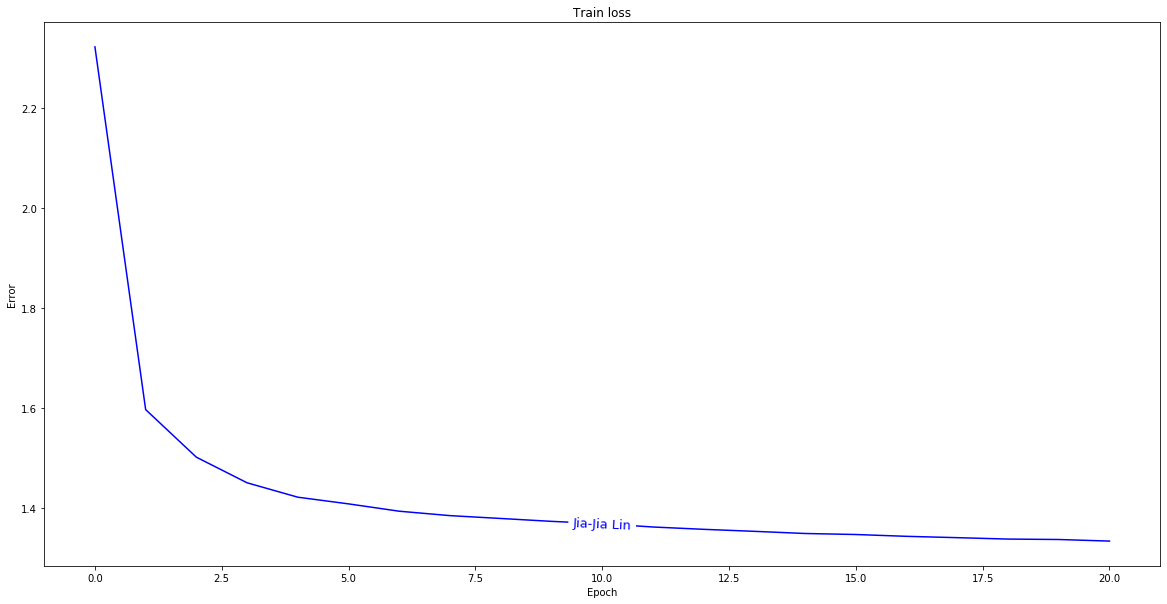

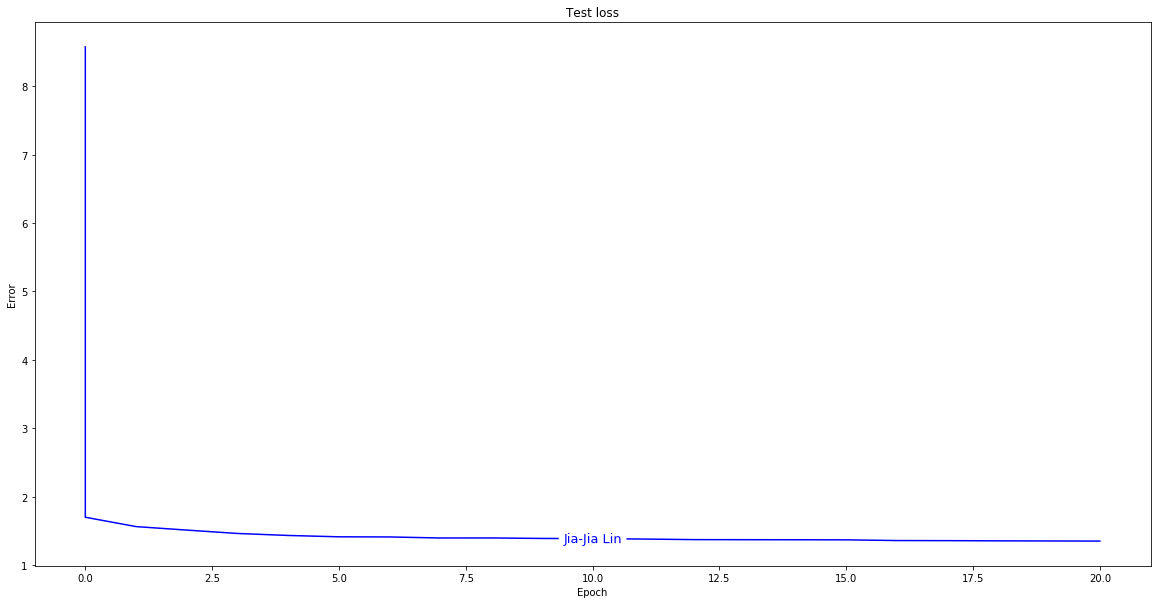

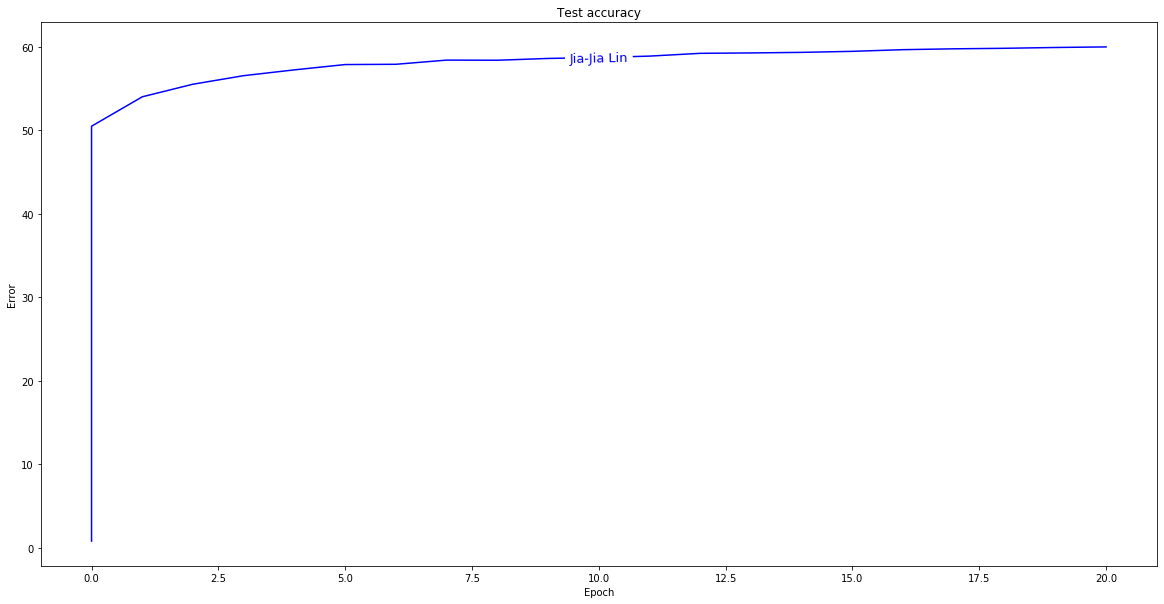

In [9]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'

    # setup GPU and multiprocessing
    use_cuda = USE_CUDA and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)
    kwargs = {'num_workers': num_workers,'pin_memory': True} if use_cuda else {}

    # get train and test data
    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE, shuffle=False, **kwargs)
    print("TESTING: ")
    print(len(test_loader))
    # initialize model
    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    # This will train from scratch
    start_epoch = 0 
    train_losses, test_losses, test_accuracies = [], [], []

    # To resume training from last saved model, uncomment the following 2 lines
    # start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
    # train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))

    # Get initial test loss and accuracy
    test_loss, test_accuracy = test(model, device, test_loader)
    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            
            # train for 1 epoch
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            train_losses.append((epoch, train_loss))
            # test after 1 epoch
            test_loss, test_accuracy = test(model, device, test_loader)
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            # Log the losses and accuracy
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            # save best model
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/language_%03d.pt' % epoch)
            
            # Test with a sentence starting with the given seed words. See what is generated next.
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated sentence\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/language_%03d.pt' % epoch, 0)
        # plot the loss and accuracy values
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error', name)
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error', name)
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error', name)
        return model, vocab, device

final_model, vocab, device = main()

# Submission.
Download a copy of this python notebook using File -> download .ipynb. Upload the following files on Canvas INDIVIDUALLY (**Do Not ZIP**):

- cse415A6.ipynb
- report.pdf
- cifar_050.pt
- language_020.pt

P.S. This codebase has been written following the codebase for the homework assignments of CSE499G1 / CSE599G1 (Introduction to Deep Learning) course during Fall 2019.